# **Predecir Ventas**

Instalaciones:
* pip install pandas
* pip install xlrd (para leer archivos de extension xls)
* pip install matplotlib
* pip install openpyxl
* pip install seaborn
* pip install scikit-learn
* pip install xgboost

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# **1.  Carga de Datos**

**Dataframe dfData**
1. leemos la data de VENTAS KERA TEIN.xlsx
2. convertimos Fecha a datetime (ya viene bien)
3. ordenamos el dataframe por Fecha
4. calculamos LunesAnterior, para hacer agrupamientos por semana, encontrando cual es el lunes anterior para cada fila (Fecha)
5. calculamos FechaMes, para agrupar por mes
6. Dejamos en el dataframe solo Fecha, LunesAnterior, FechaMes y Cant. pedida



In [14]:
dfData = pd.read_excel('../Data Original/VENTAS KERA TEIN.xls')
#df = df[['Fecha','Fecha entrega','Cant. pedida', 'Cant. pendiente', 'Cant. comprom.', 'Cant. remision', 'Cant. factura']]
dfData = dfData[['Fecha','Cant. pedida']]
dfData = dfData.sort_values(by='Fecha')


# Función para obtener el lunes anterior a una fecha dada
def obtener_lunes_anterior(fecha):
    # Calcular el lunes anterior
    lunes_anterior = fecha - pd.DateOffset(days=fecha.weekday())
    return lunes_anterior

dfData['LunesAnterior'] = dfData['Fecha'].apply(obtener_lunes_anterior)

# Establecer la columna 'Fecha' como el índice del DataFrame
dfData['FechaMes'] = dfData['Fecha'].dt.to_period('M').dt.to_timestamp()

dfData = dfData[['Fecha','LunesAnterior','FechaMes','Cant. pedida']]

# **2. Agrupamientos**
Se logran agrupamientos por:
1. día:  Fecha --> sum('Cant. pedida')
2. semana:  LunesAnterior--> sum('Cant. pedida')
3. mes:  FechaMes --> sum('Cant. pedida')

In [15]:
df_dia = dfData.groupby('Fecha').agg({'Cant. pedida':'sum'}).reset_index()
df_semana = dfData.groupby('LunesAnterior').agg({'Cant. pedida':'sum'}).reset_index()
df_mes = dfData.groupby('FechaMes').agg({'Cant. pedida':'sum'}).reset_index()

df_mes.head()

,FechaMes,Cant. pedida
0,2017-09-01,120.0
1,2017-11-01,40.0
2,2017-12-01,80.0
3,2018-01-01,80.0
4,2018-02-01,120.0


# **3.  lectura del data adicional**

* **Dólar:  df_dolar**:  Trae el cambio del dólar por dia
* **Desempleo: df_desempleo**: Trae el cambio del IPC por mes

In [16]:
df_dolar = pd.read_csv('../Data Original/Datos históricos USD_COP.csv')

df_dolar['Fecha'] = pd.to_datetime(df_dolar['Fecha'], format='%d.%m.%Y')
df_dolar['Apertura']  = df_dolar['Apertura'].str.replace('.', '').str.replace(',', '.').astype(float)
df_dolar = df_dolar[['Fecha','Apertura']].copy()

df_dolar.rename(columns={'Apertura':'Dolar'}, inplace=True)
df_dolar=df_dolar.sort_values(by='Fecha', ascending=True).reset_index(drop=True)

df_dolar['FechaMes'] =  df_dolar['Fecha'].dt.to_period('M').dt.to_timestamp()
print('df_dolar:')
print(df_dolar.head())

df_desempleo = pd.read_excel('../Data Original/Desempleo.xlsx')
df_desempleo = df_desempleo[df_desempleo['Fecha']>='2016-01-01']
df_desempleo.columns = ['FechaMes','Desempleo']
df_desempleo.reset_index(inplace=True,drop=True)
print('')
print('df_desempleo:')
print(df_desempleo.head())

df_dolar:
       Fecha    Dolar   FechaMes
0 2016-01-01  3179.00 2016-01-01
1 2016-01-04  3175.65 2016-01-01
2 2016-01-05  3219.34 2016-01-01
3 2016-01-06  3212.00 2016-01-01
4 2016-01-07  3254.42 2016-01-01

df_desempleo:
    FechaMes  Desempleo
0 2016-01-31      12.18
1 2016-02-29      10.37
2 2016-03-31      10.46
3 2016-04-30       9.32
4 2016-05-31       9.24


# **3. Graficación**

Observamos con SeaBorn si la data tiene cierto comportamiento en el tiempo

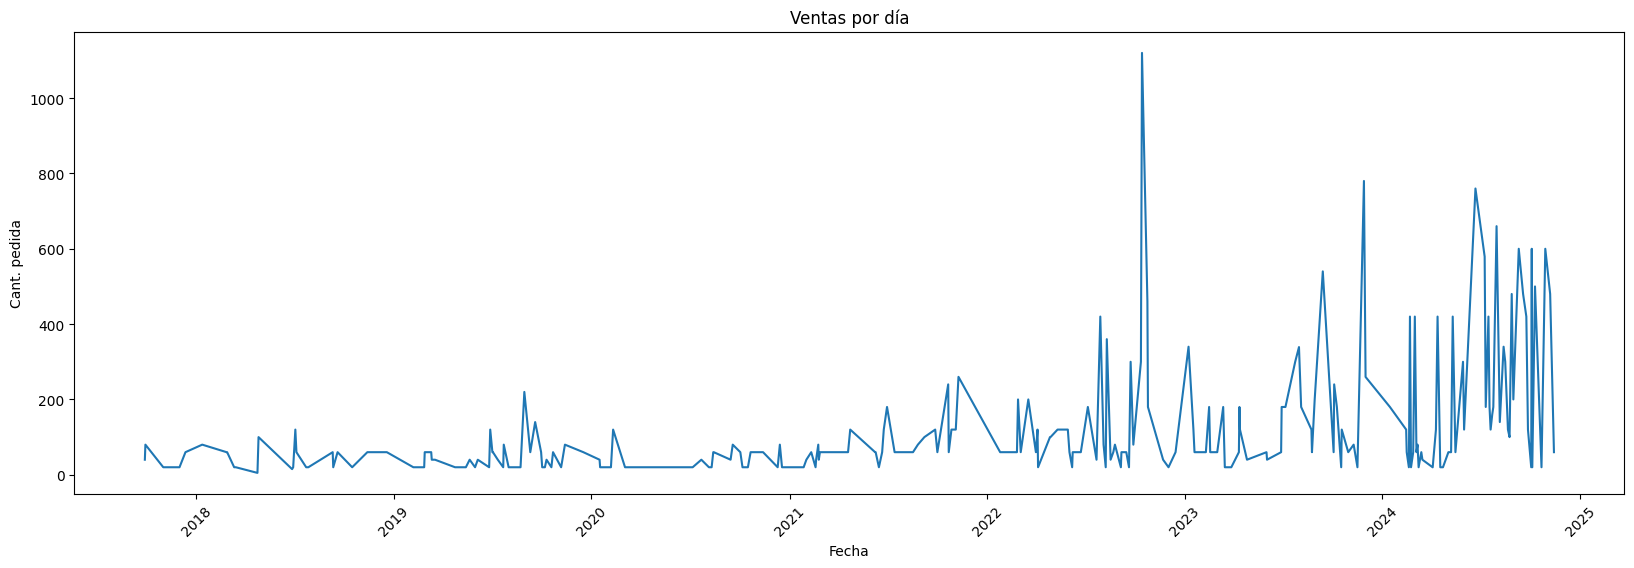

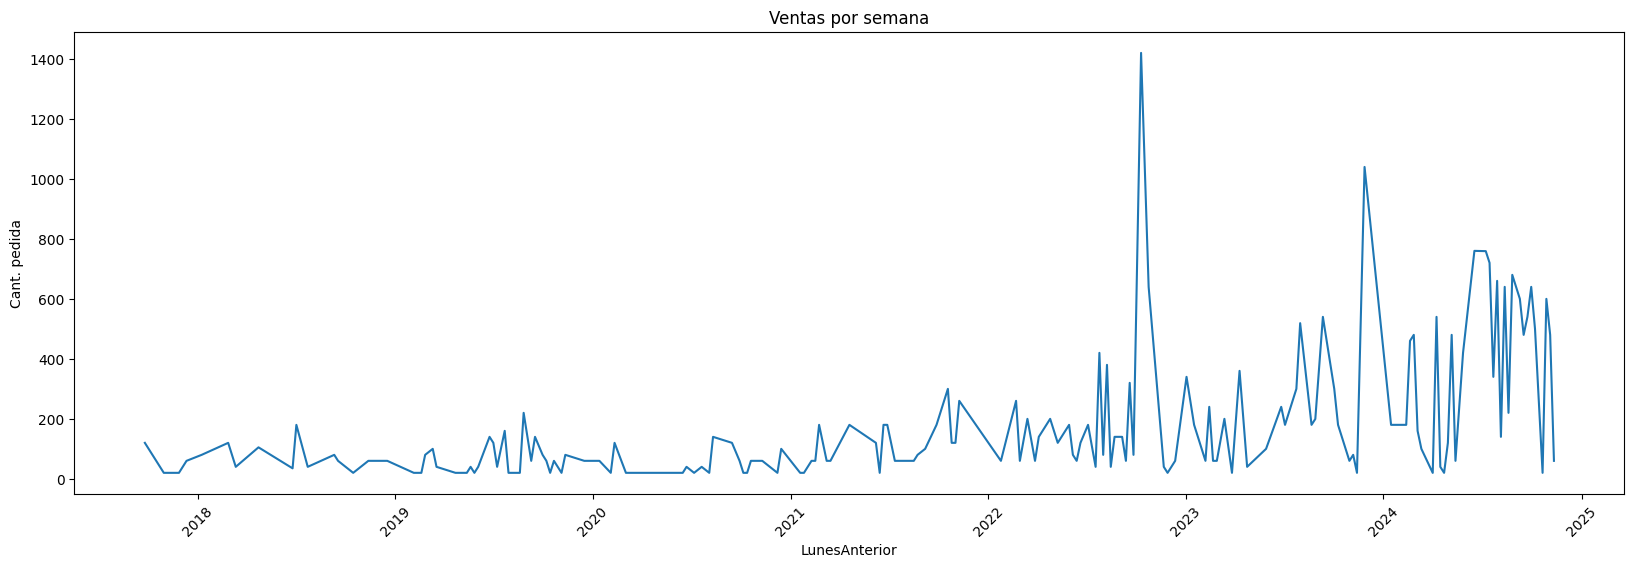

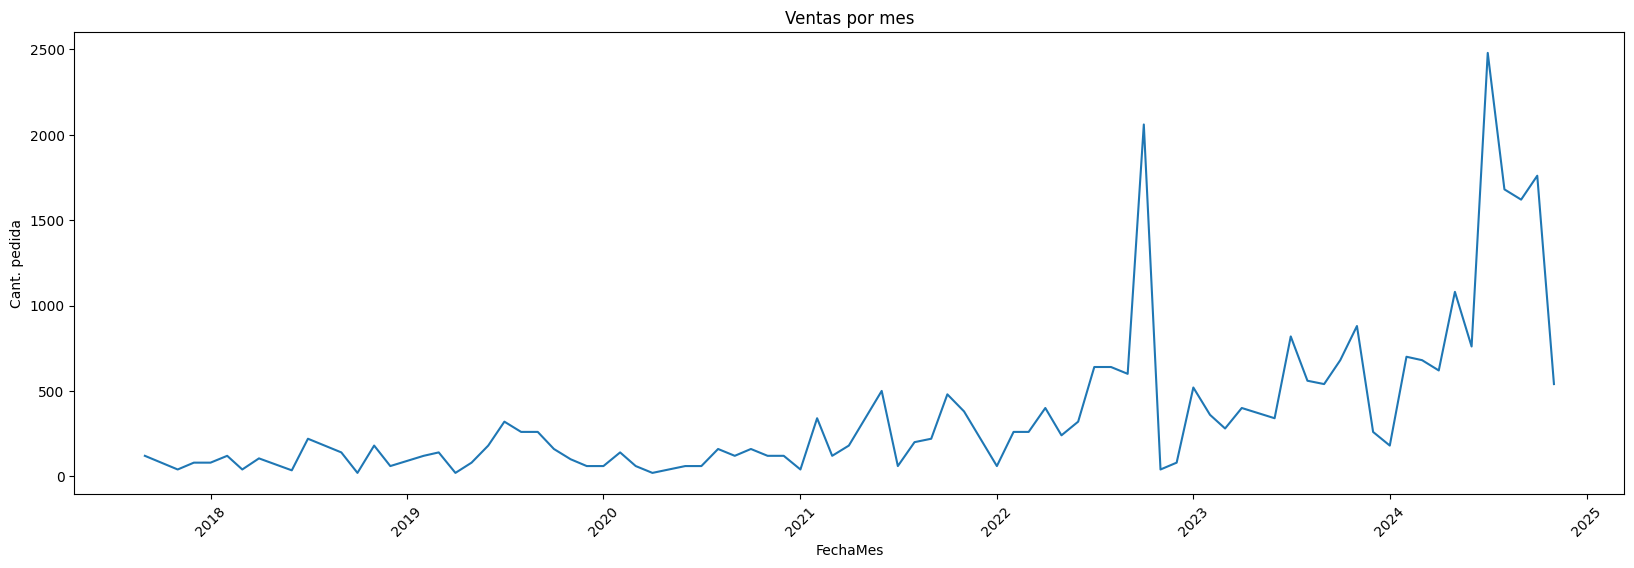

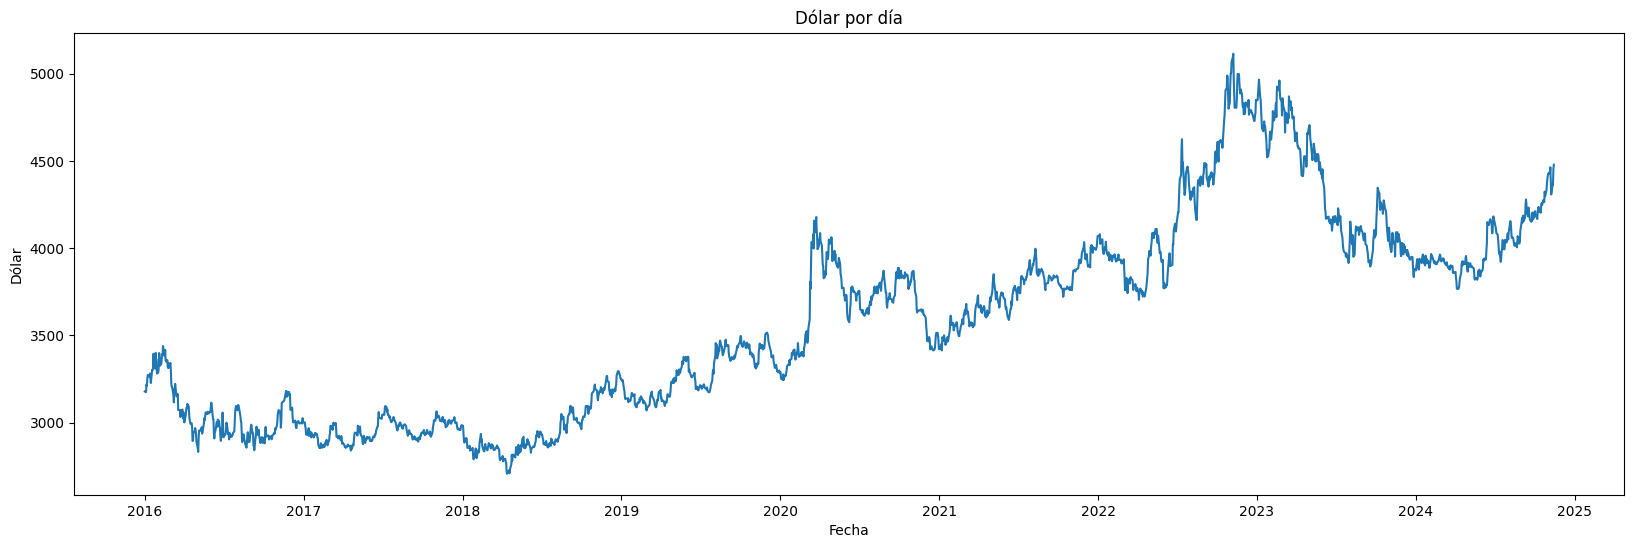

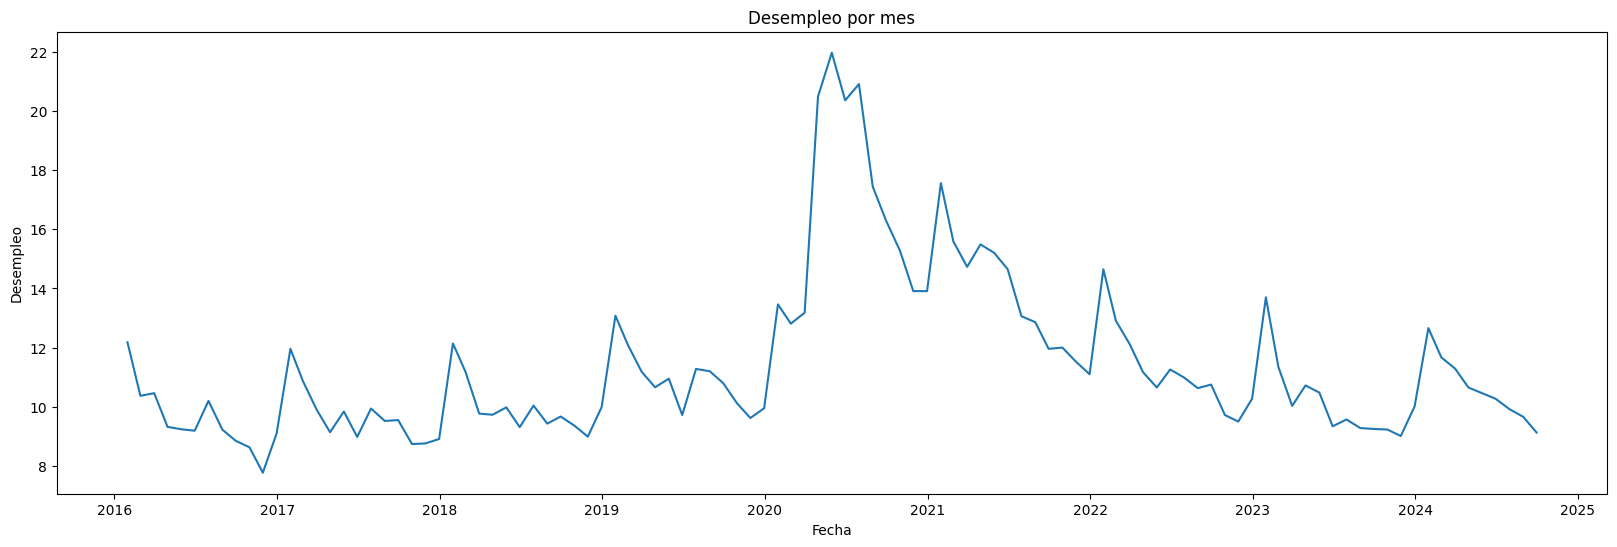

In [17]:
# VENTAS POR DIA
plt.figure(figsize=(20, 6))
sns.lineplot(x='Fecha', y='Cant. pedida', data=df_dia)
plt.xticks(rotation=45)
plt.title('Ventas por día')
plt.show()

# VENTAS POR SEMANA
plt.figure(figsize=(20, 6))
sns.lineplot(x='LunesAnterior', y='Cant. pedida', data=df_semana)
plt.xticks(rotation=45)
plt.title('Ventas por semana')
plt.show()

# VENTAS POR MES
plt.figure(figsize=(20, 6))
sns.lineplot(x='FechaMes', y='Cant. pedida', data=df_mes)
plt.xticks(rotation=45)
plt.title('Ventas por mes')
plt.show()

# VALOR DEL DOLAR 
plt.figure(figsize=(20, 6))
sns.lineplot(data=df_dolar, x='Fecha', y='Dolar')
plt.title('Dólar por día')
plt.xlabel('Fecha')
plt.ylabel('Dólar')
plt.show()

# DESEMPLEO POR MES
plt.figure(figsize=(20, 6))
sns.lineplot(data=df_desempleo, x='FechaMes', y='Desempleo')
plt.title('Desempleo por mes')
plt.xlabel('Fecha')
plt.ylabel('Desempleo')
plt.show()

# **4. Agrupamientos por MES**
Como primer intento, vamos a llevar todos los datos a mensual.  
* **df_mes**: ya está agrupado mensual los datos de ventas por mes
* **df_dolar_mes**:  agrupamiento del valor del dolar en el mes, obteniendo max, min y mean por cada mes
* **df_desempleo**: hay que ajustar la fecha para que en cada mes apunte al primer día de cada mes

In [18]:
print('\n Ventas por mes: df_mes')
print(df_mes.head())

# DOLAR POR MES
df_dolar_mes = df_dolar.groupby('FechaMes').agg({'Dolar':['max','min','mean']}).reset_index()
df_dolar_mes.columns = ['FechaMes','dolar_max','dolar_min','dolar_mean']
print('\n df_dolar_mes:')
print(df_dolar_mes.head())

# DESEMPLEO POR MES:   viene con fechas que cambian.   se colocan todos como el primer día del mes.
df_desempleo['FechaMes'] = (df_desempleo['FechaMes'] + pd.offsets.MonthBegin(1)).dt.to_period('M').dt.to_timestamp()
print('\n df_desempleo:')
print(df_desempleo.head())


 Ventas por mes: df_mes
    FechaMes  Cant. pedida
0 2017-09-01         120.0
1 2017-11-01          40.0
2 2017-12-01          80.0
3 2018-01-01          80.0
4 2018-02-01         120.0

 df_dolar_mes:
    FechaMes  dolar_max  dolar_min   dolar_mean
0 2016-01-01    3400.69    3175.65  3283.536190
1 2016-02-01    3439.38    3286.48  3358.501429
2 2016-03-01    3304.60    3025.28  3131.798696
3 2016-04-01    3108.00    2889.71  2998.006190
4 2016-05-01    3063.13    2833.00  2991.684091

 df_desempleo:
    FechaMes  Desempleo
0 2016-02-01      12.18
1 2016-03-01      10.37
2 2016-04-01      10.46
3 2016-05-01       9.32
4 2016-06-01       9.24


# **5.  Unimos dataframe por MES**

* se crea el dataframe dfTotal que es un INNER JOIN entre df_mes, df_dolar_mes y df_desempleo
* adicionamos dos columnas nuevas:
    * Mes:  que tiene el nombre del mes.  esto para extraer más información de la fecha
    * Trimestre:  que se obtiene del mes, y nos permite obtener información por trimestres
* se normaliza usando MinMax()

In [19]:
dfTotal = pd.merge(df_mes, df_dolar_mes, on='FechaMes', how='inner')
dfTotal = pd.merge(dfTotal, df_desempleo, on='FechaMes', how='inner')

dfTotal['Mes'] = dfTotal['FechaMes'].dt.month
dfTotal['Trimestre'] = dfTotal['FechaMes'].dt.quarter

# **6. FUNCION HISTÓRICA**

un hiperparámetro a determinar, es cuanta historia usar para predecir el siguiente mes.
Para facilitar esto, se crea una función que toma el dataframe y un parámetro h (historia, int) y que retorna un nuevo dataframe donde el valor a predecir estará acompañado de las historia h de todas las otras variables desde los h meses anteriores.

Ejemplo:  si t = 100, se coloca Label[t] y se completa con dolar_max[t-1-h:t-1], Desempleo[t-1-h: t-1], etc.

In [28]:
import numpy as np
def convierte_df_historico(df, historia):
    
    arreglo = []

    for i in range(historia, len(df)):   
        fila = [df['Cant. pedida'].iloc[i].tolist()]
        dolar_max = df['dolar_max'].iloc[i-historia:i].tolist()
        fila.extend(dolar_max)
        dolar_min = df['dolar_min'].iloc[i-historia:i].tolist()
        fila.extend(dolar_min)
        dolar_mean = df['dolar_mean'].iloc[i-historia:i].tolist()
        fila.extend(dolar_mean)
        Desempleo = df['Desempleo'].iloc[i-historia:i].tolist()
        fila.extend(Desempleo)
        Mes = df['Mes'].iloc[i-historia:i].tolist()
        fila.extend(Mes)
        Trimestre = df['Trimestre'].iloc[i-historia:i].tolist()
        fila.extend(Trimestre)

        arreglo.append(fila)
    return(np.array(arreglo))

# **8. Obtenemos históricos, escalamos, separamos Train y Test y  generamos modelos**

(76,) (76, 6)
(76,) (76, 6)
Random Forest Regressor:
Mejores parámetros: {'max_depth': 10, 'n_estimators': 100}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.27

Neural Network Regressor:
Mejores parámetros: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.29

XGBoost Regressor:
Mejores parámetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.30


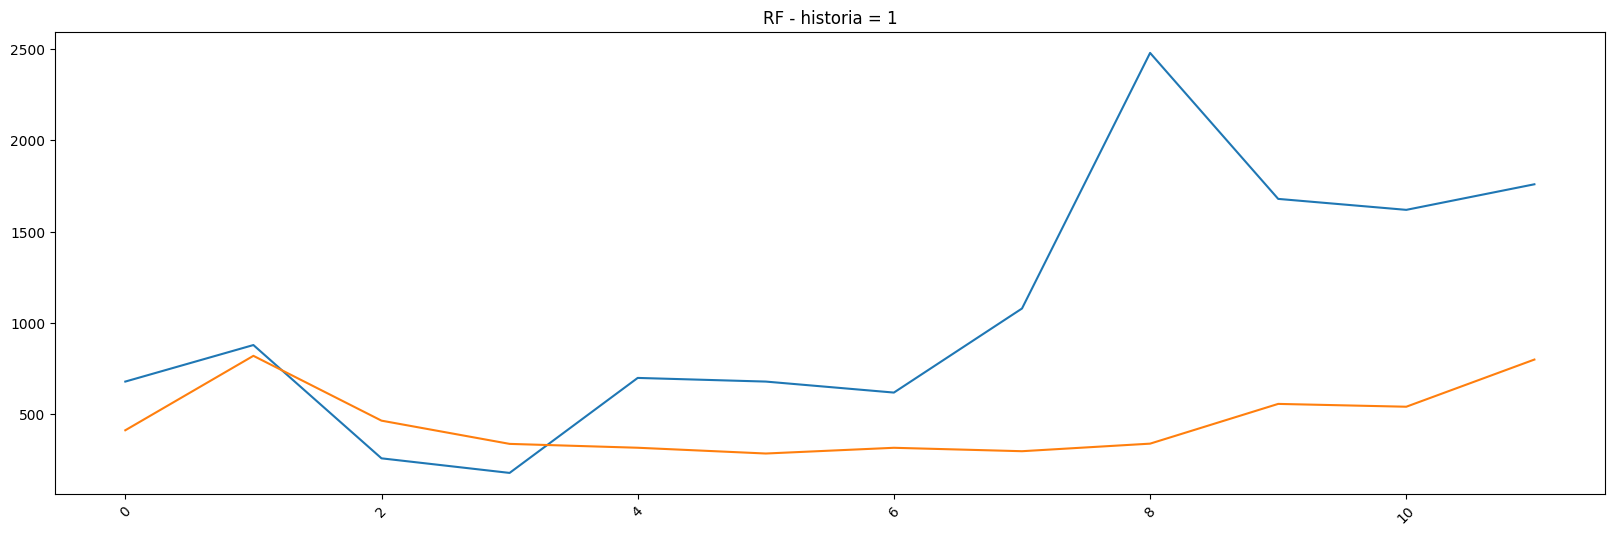

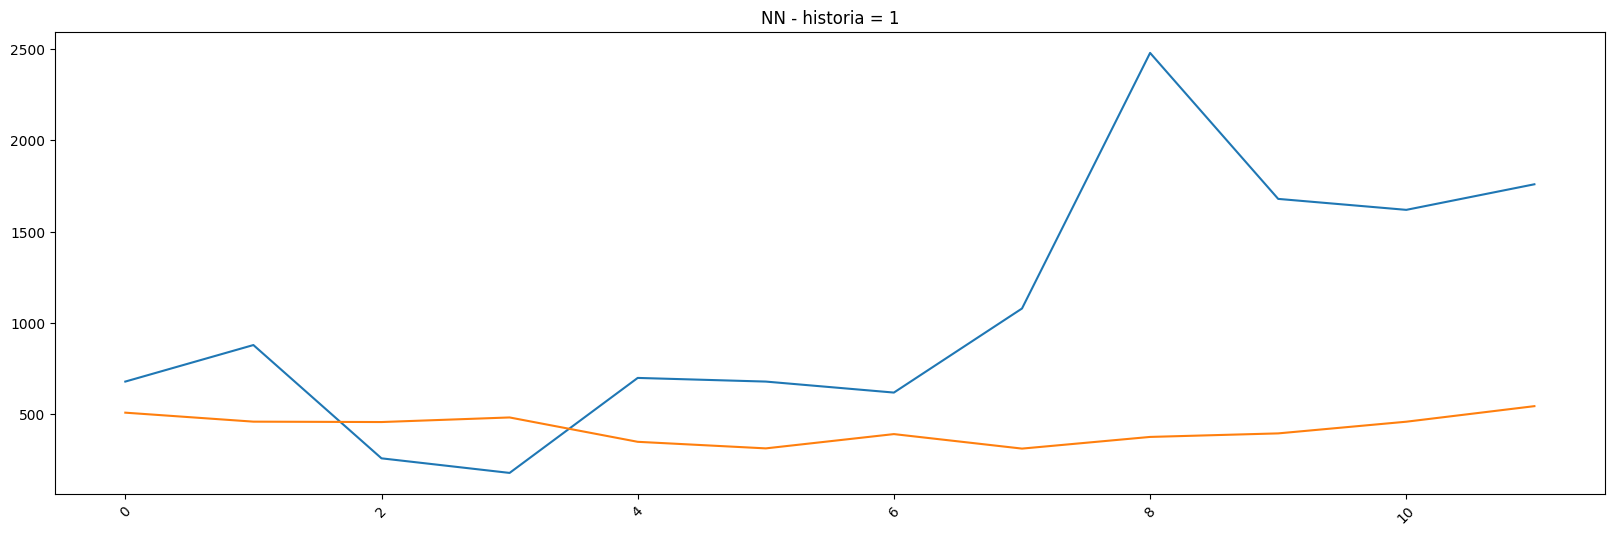

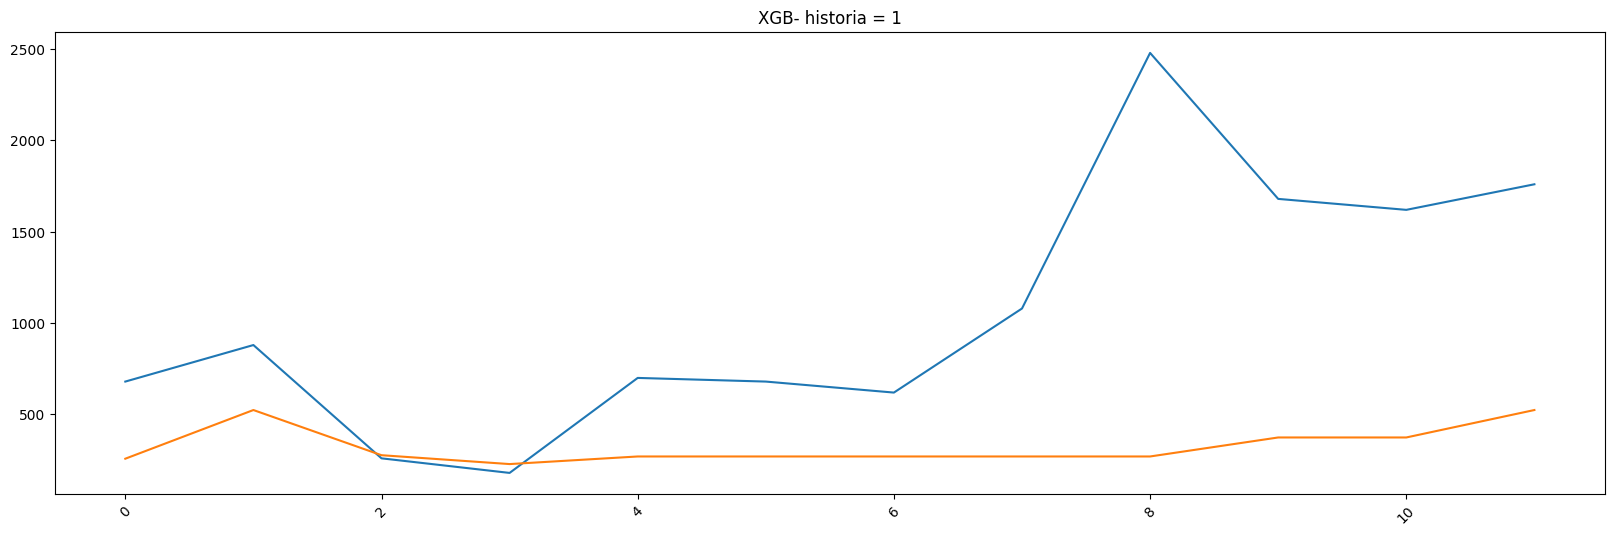

(75,) (75, 12)
(75,) (75, 12)
Random Forest Regressor:
Mejores parámetros: {'max_depth': 30, 'n_estimators': 50}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.26

Neural Network Regressor:
Mejores parámetros: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.25

XGBoost Regressor:
Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Mejor precisión (neg_mean_absolute_error): -0.07
Error absoluto medio (MAE): 0.27


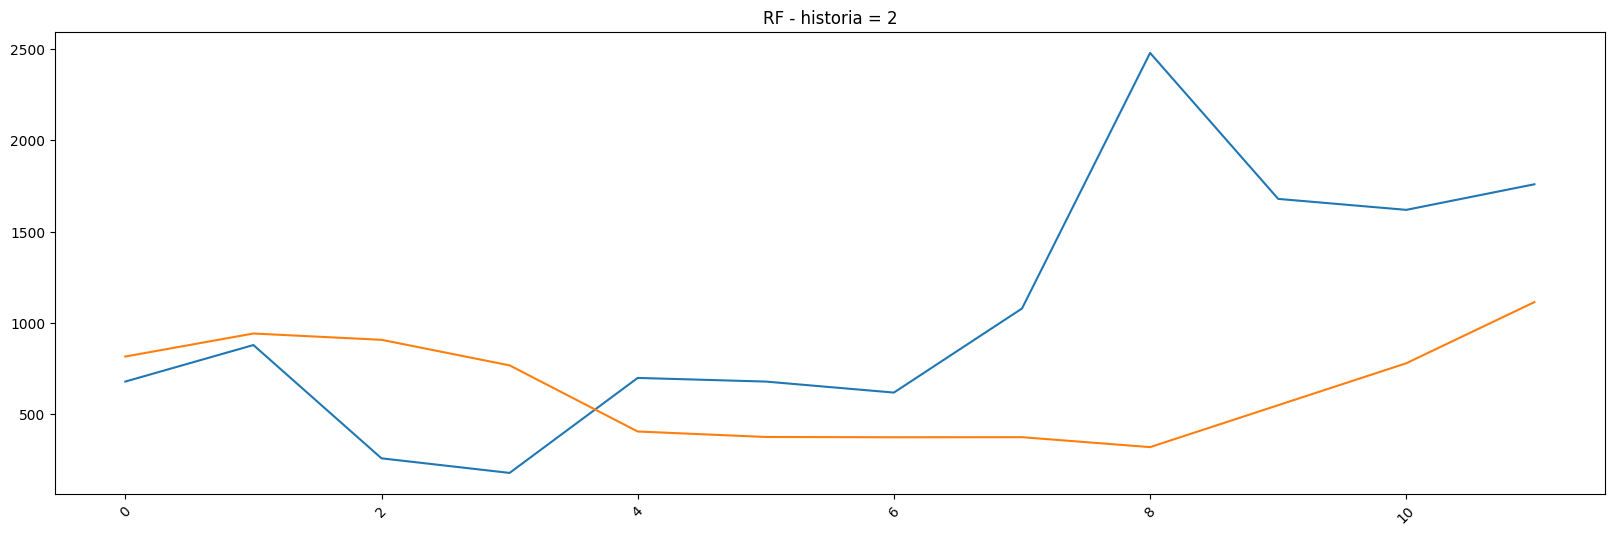

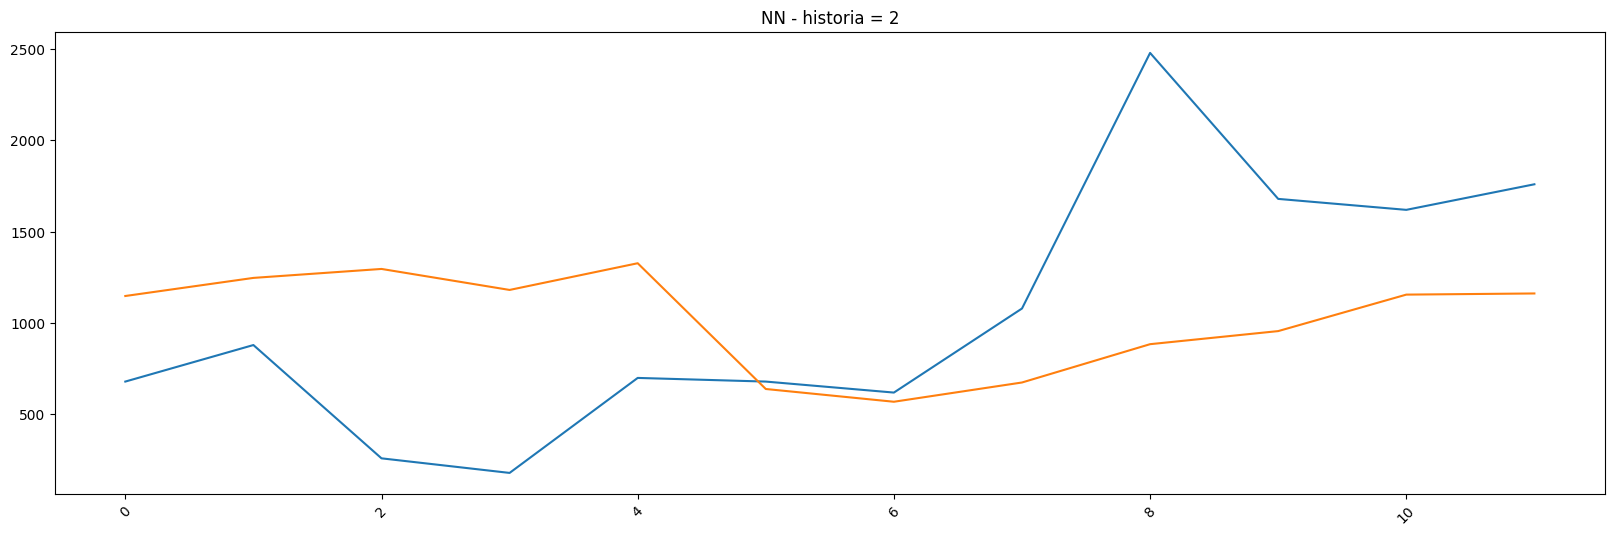

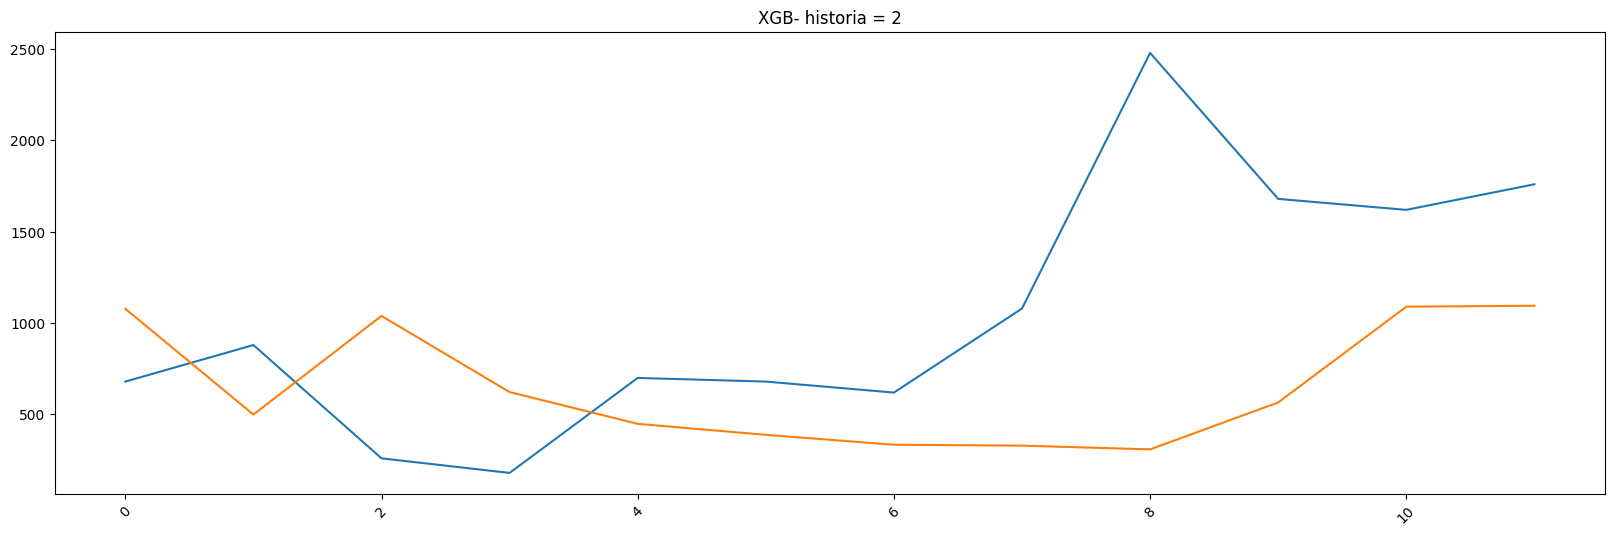

(74,) (74, 18)
(74,) (74, 18)
Random Forest Regressor:
Mejores parámetros: {'max_depth': 30, 'n_estimators': 100}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.27

Neural Network Regressor:
Mejores parámetros: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Mejor precisión (neg_mean_absolute_error): -0.07
Error absoluto medio (MAE): 0.31

XGBoost Regressor:
Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.28


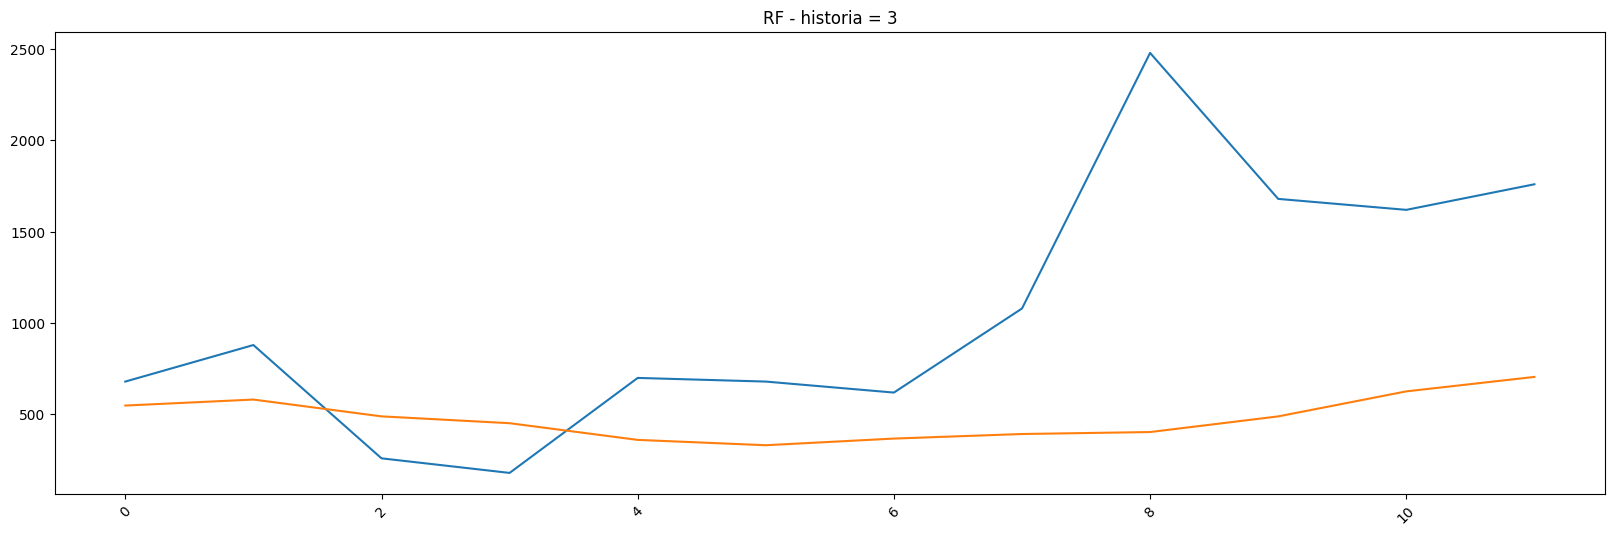

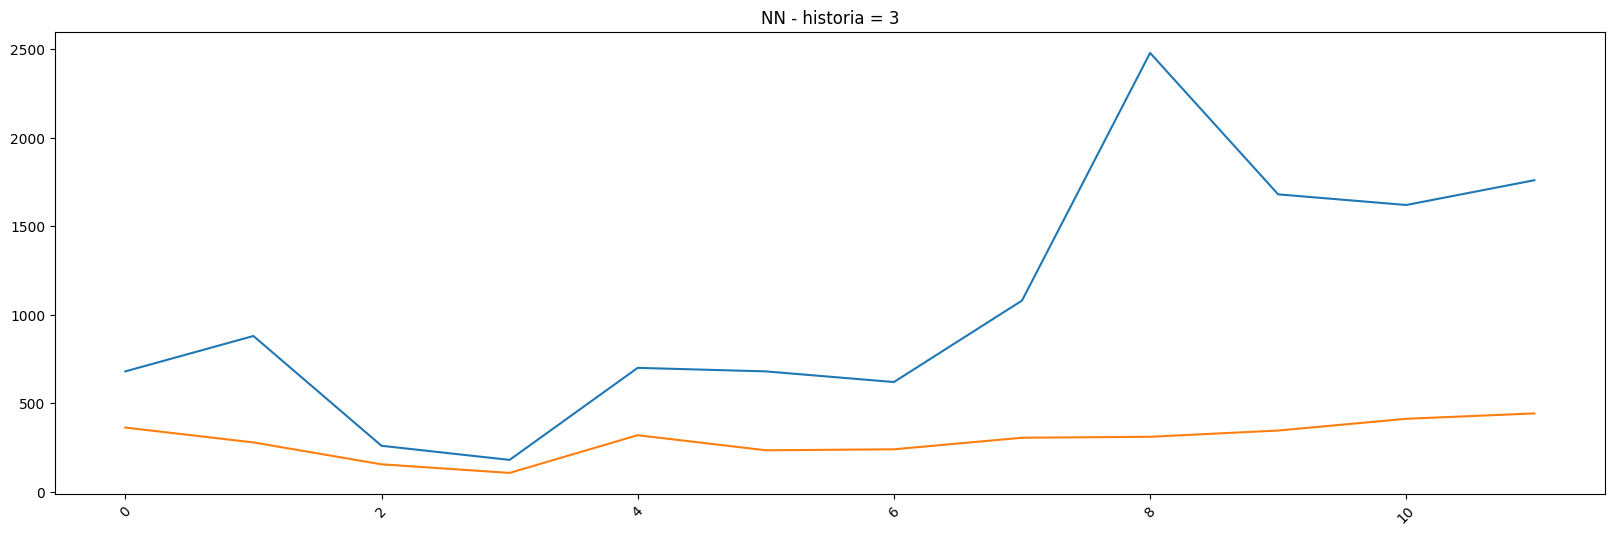

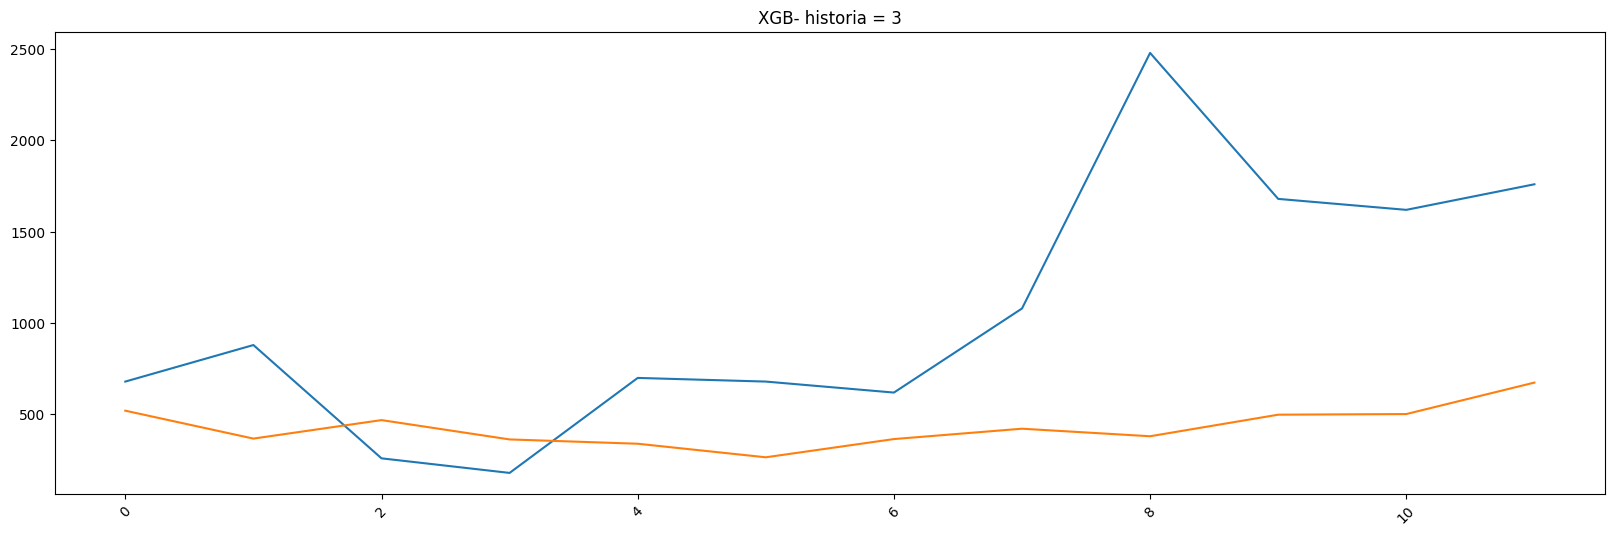

(73,) (73, 24)
(73,) (73, 24)
Random Forest Regressor:
Mejores parámetros: {'max_depth': 20, 'n_estimators': 50}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.28

Neural Network Regressor:
Mejores parámetros: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Mejor precisión (neg_mean_absolute_error): -0.07
Error absoluto medio (MAE): 0.27

XGBoost Regressor:
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.29


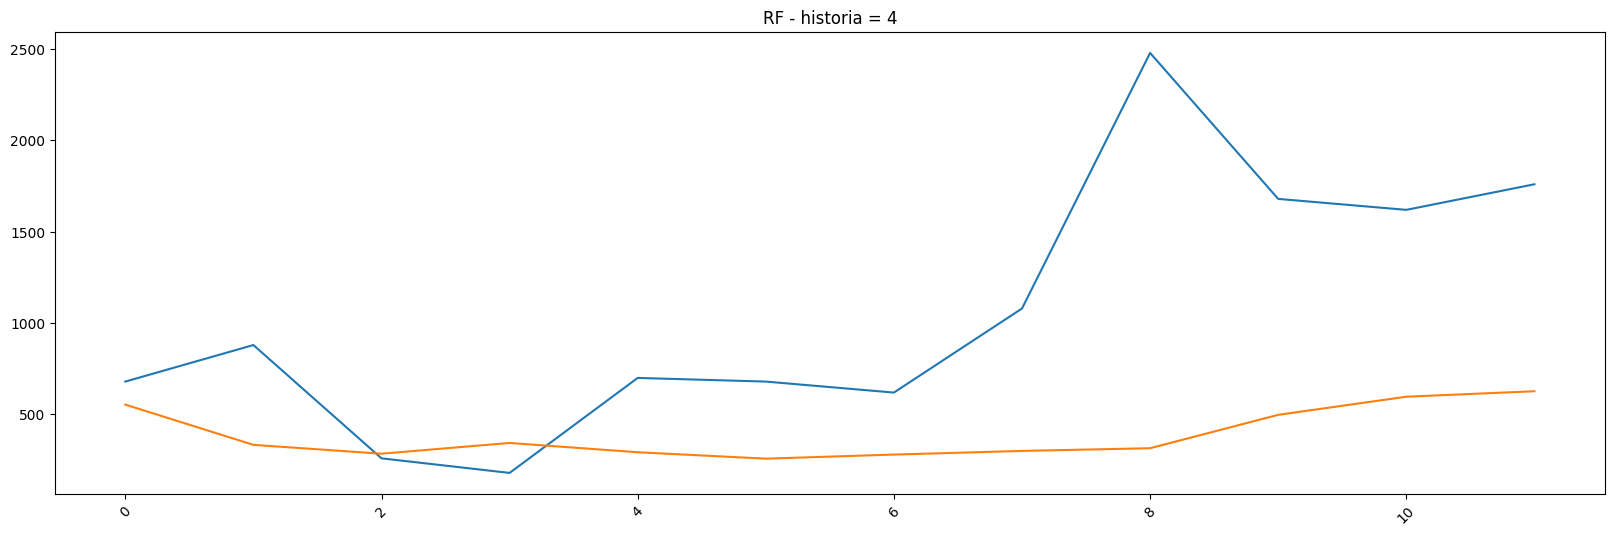

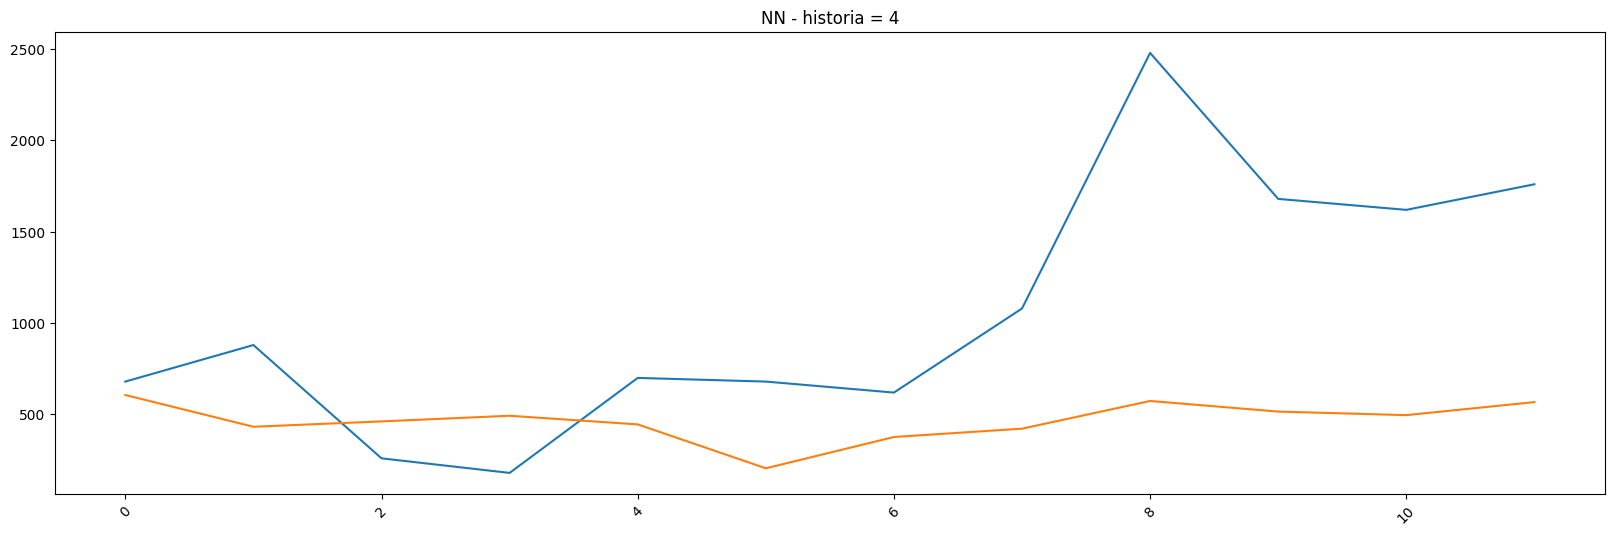

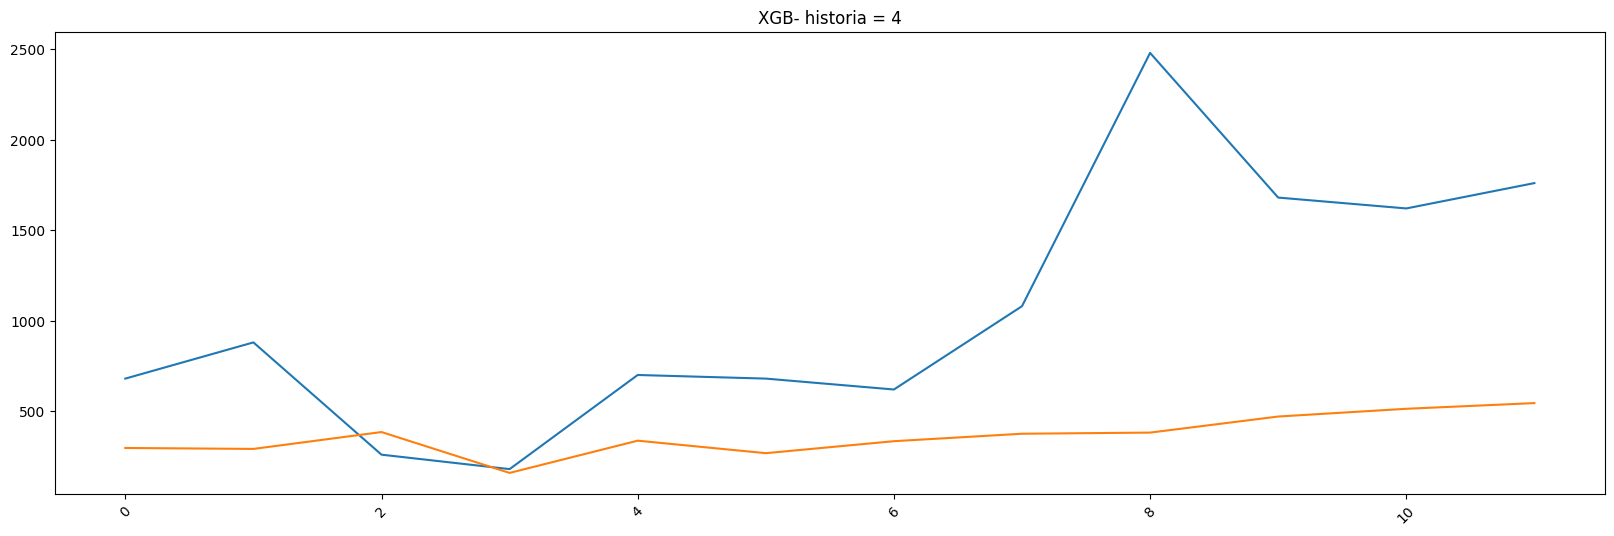

(72,) (72, 30)
(72,) (72, 30)
Random Forest Regressor:
Mejores parámetros: {'max_depth': 10, 'n_estimators': 200}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.29

Neural Network Regressor:
Mejores parámetros: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Mejor precisión (neg_mean_absolute_error): -0.07
Error absoluto medio (MAE): 0.25

XGBoost Regressor:
Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.31


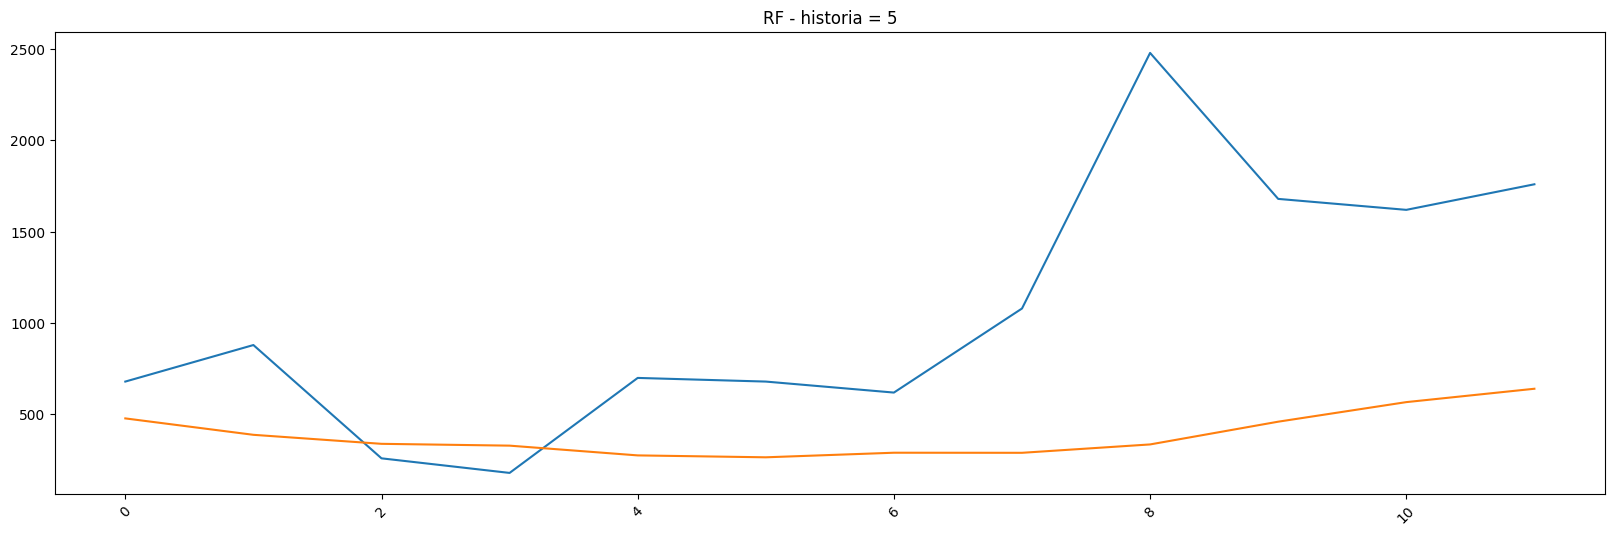

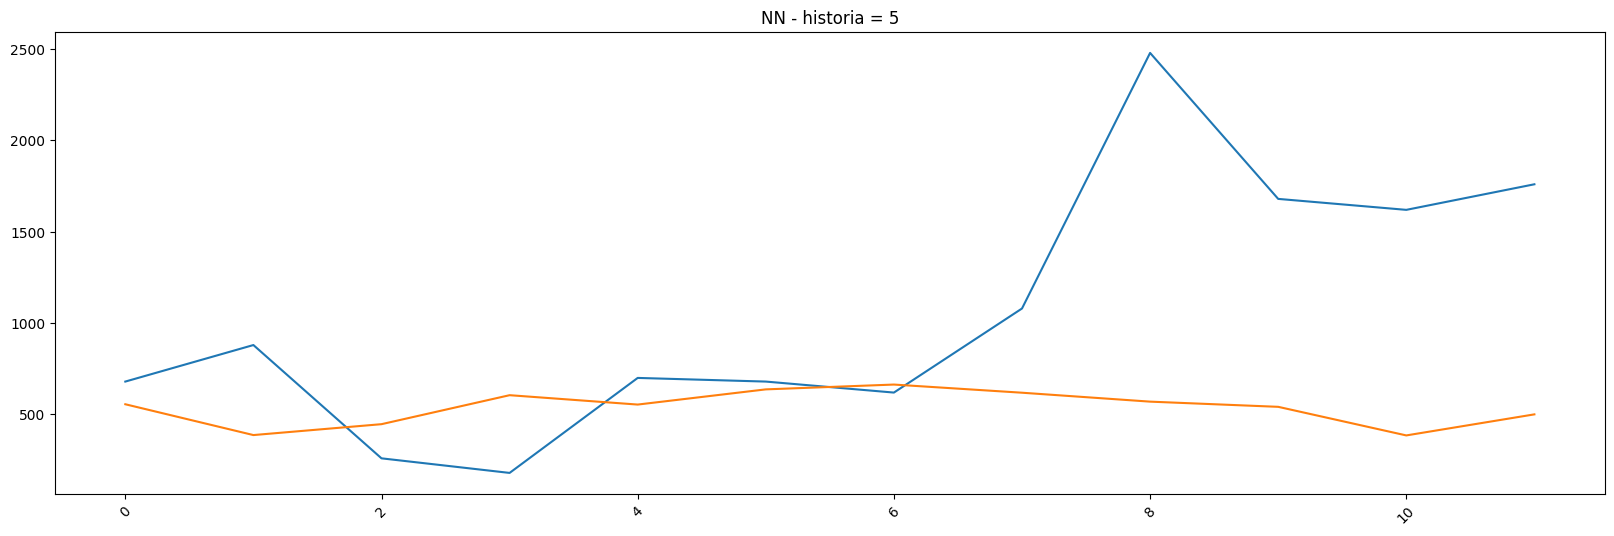

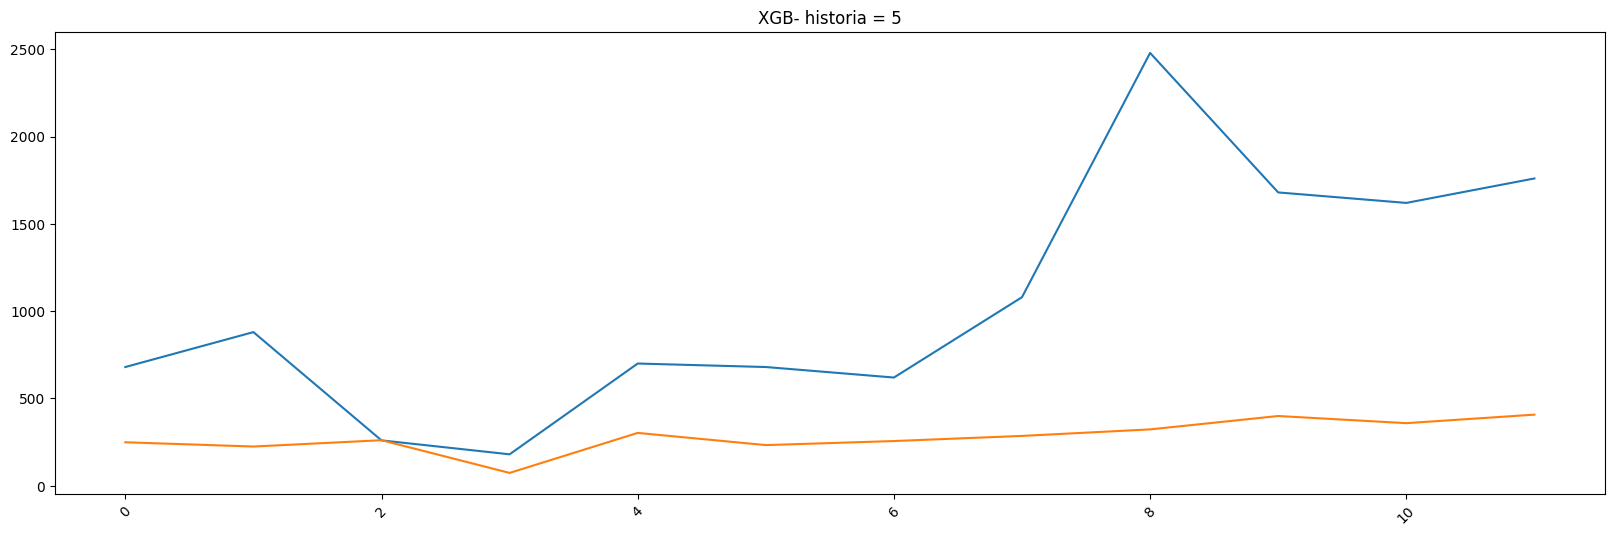

(71,) (71, 36)
(71,) (71, 36)
Random Forest Regressor:
Mejores parámetros: {'max_depth': 10, 'n_estimators': 50}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.28

Neural Network Regressor:
Mejores parámetros: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Mejor precisión (neg_mean_absolute_error): -0.07
Error absoluto medio (MAE): 0.29

XGBoost Regressor:
Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.28


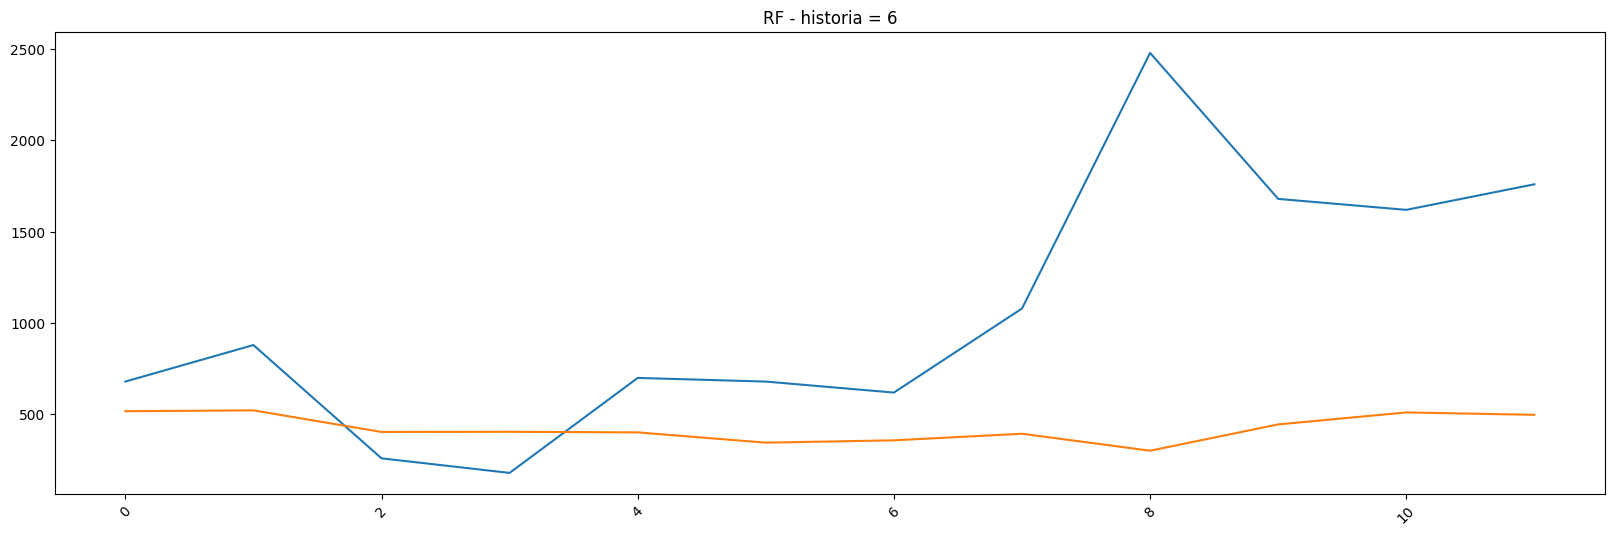

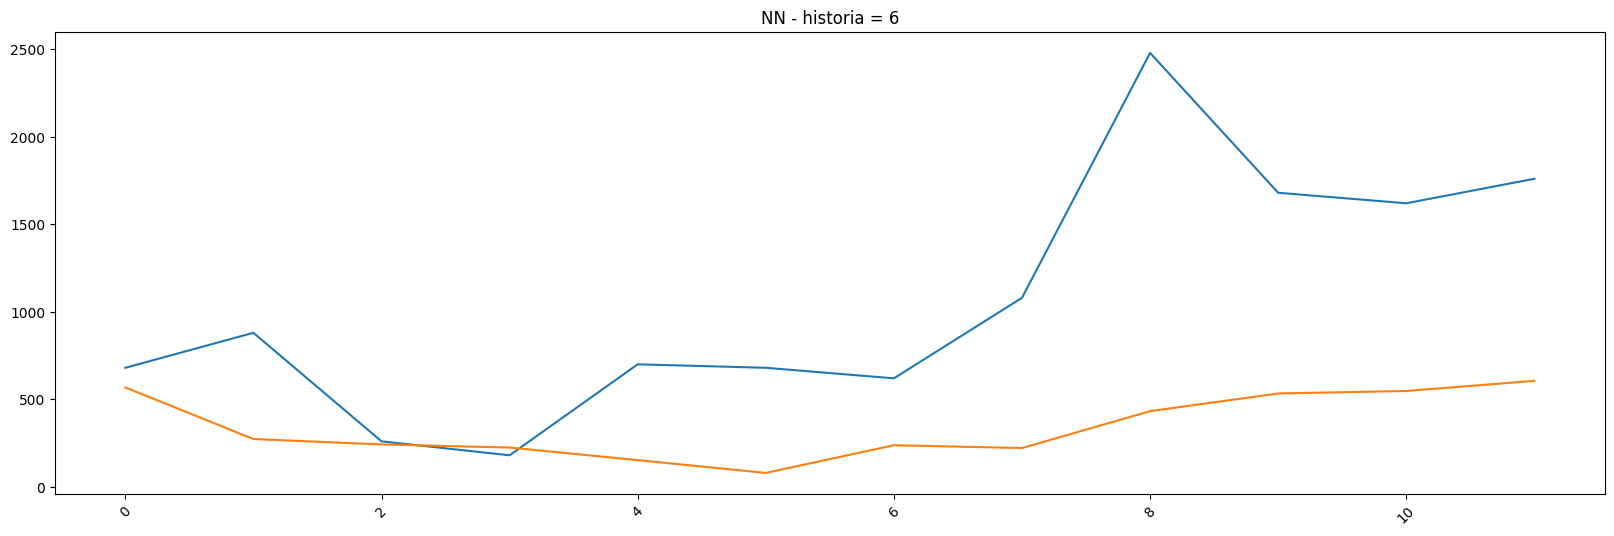

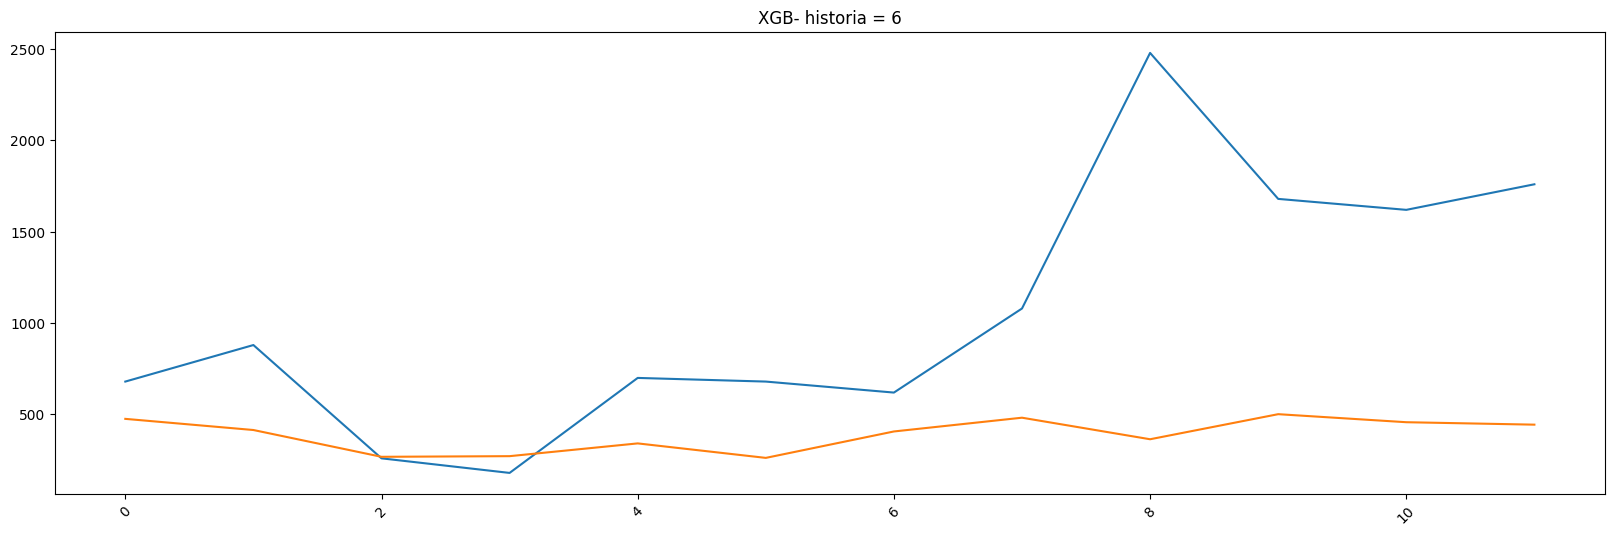

(70,) (70, 42)
(70,) (70, 42)
Random Forest Regressor:
Mejores parámetros: {'max_depth': 30, 'n_estimators': 50}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.26

Neural Network Regressor:
Mejores parámetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Mejor precisión (neg_mean_absolute_error): -0.08
Error absoluto medio (MAE): 0.28

XGBoost Regressor:
Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.30


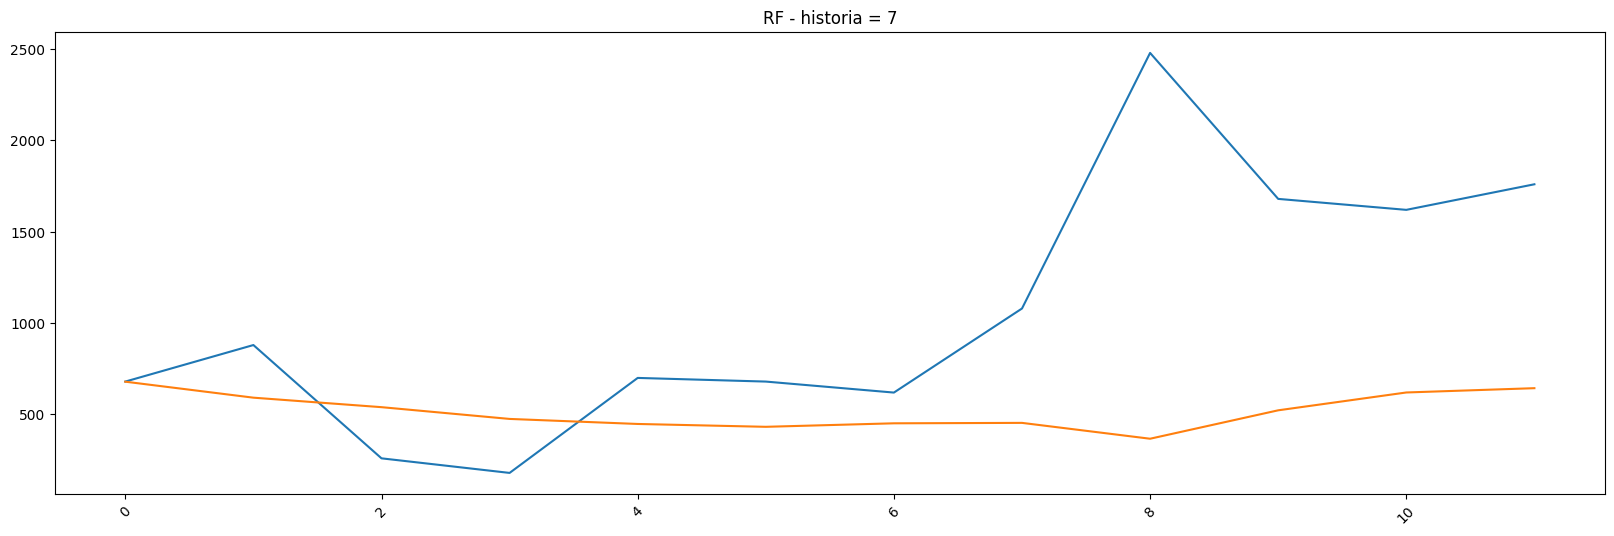

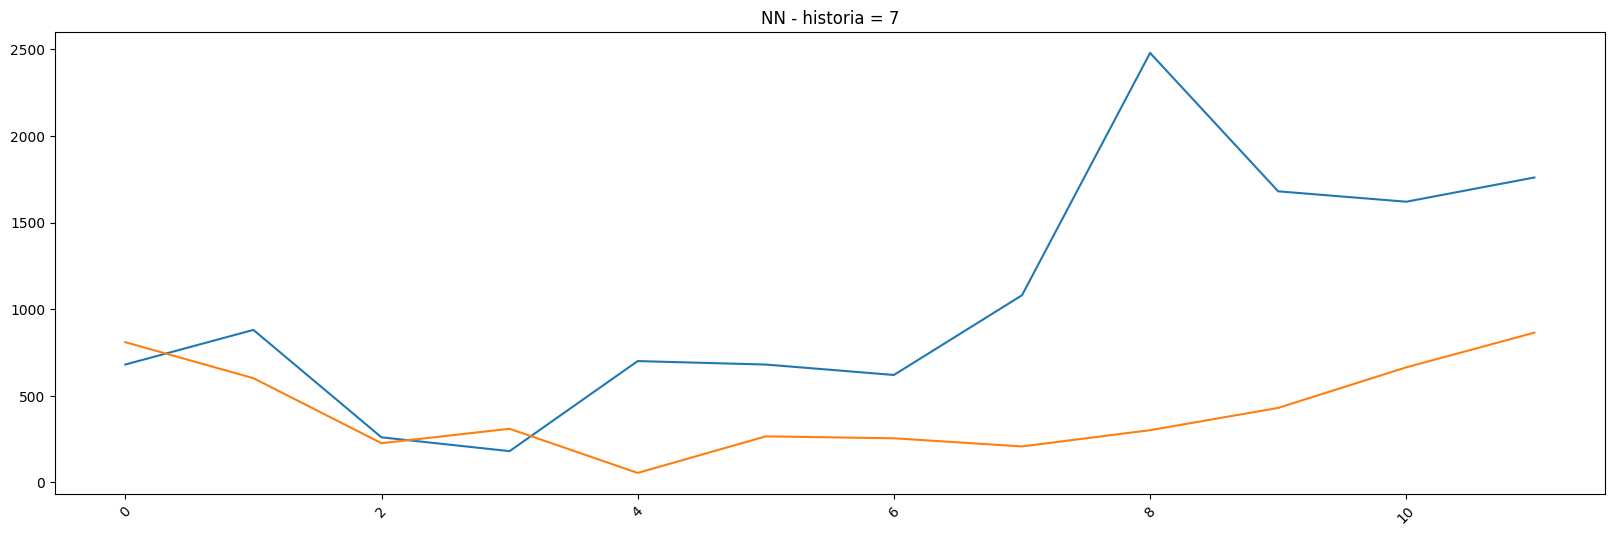

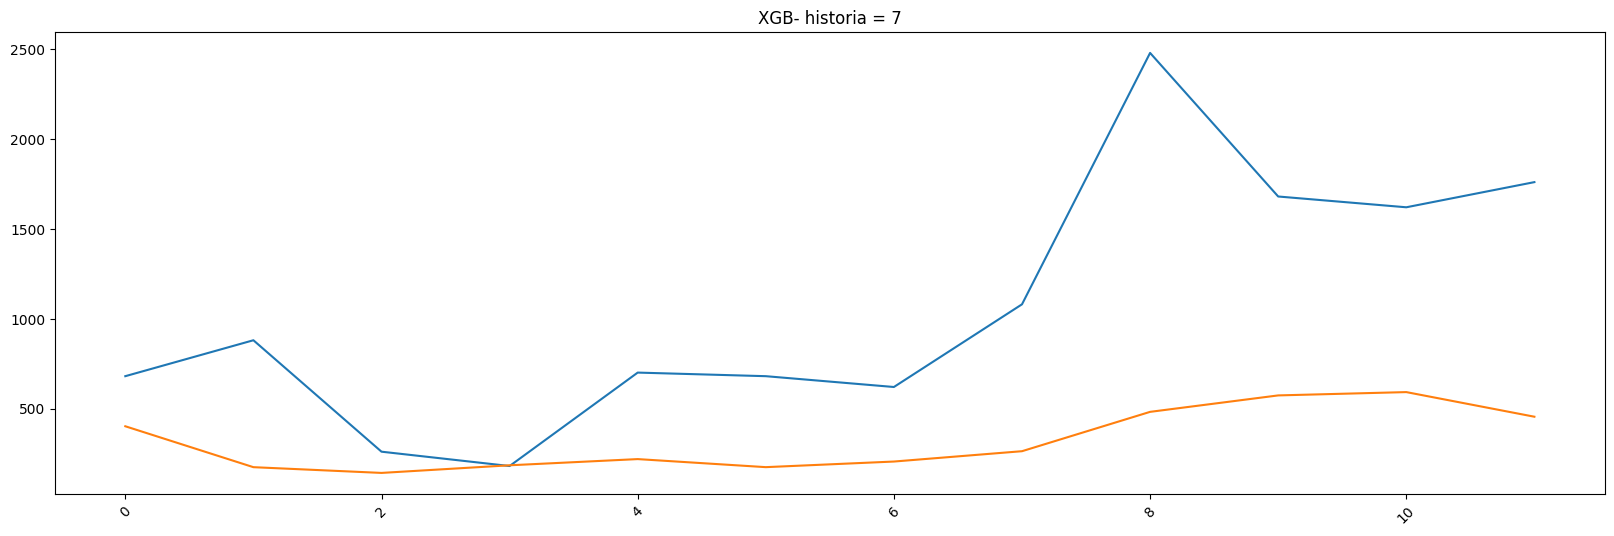

(69,) (69, 48)
(69,) (69, 48)
Random Forest Regressor:
Mejores parámetros: {'max_depth': 30, 'n_estimators': 200}
Mejor precisión (neg_mean_absolute_error): -0.07
Error absoluto medio (MAE): 0.22

Neural Network Regressor:
Mejores parámetros: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Mejor precisión (neg_mean_absolute_error): -0.09
Error absoluto medio (MAE): 0.30

XGBoost Regressor:
Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Mejor precisión (neg_mean_absolute_error): -0.07
Error absoluto medio (MAE): 0.26


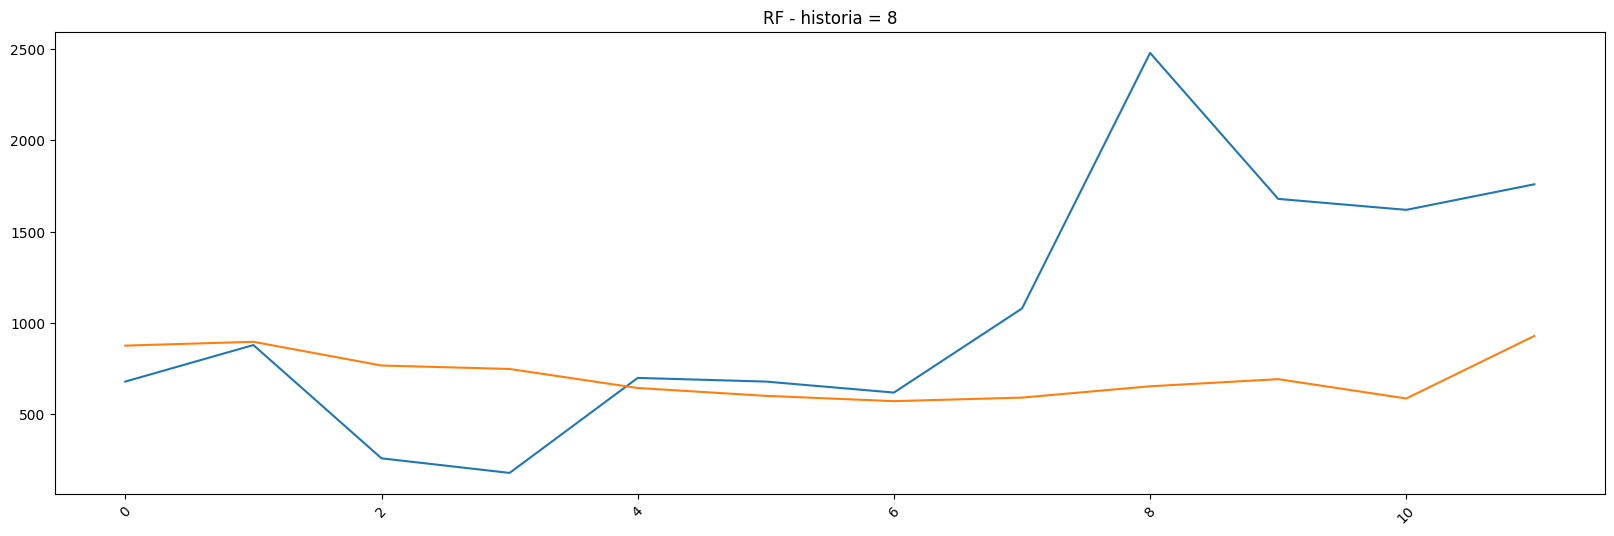

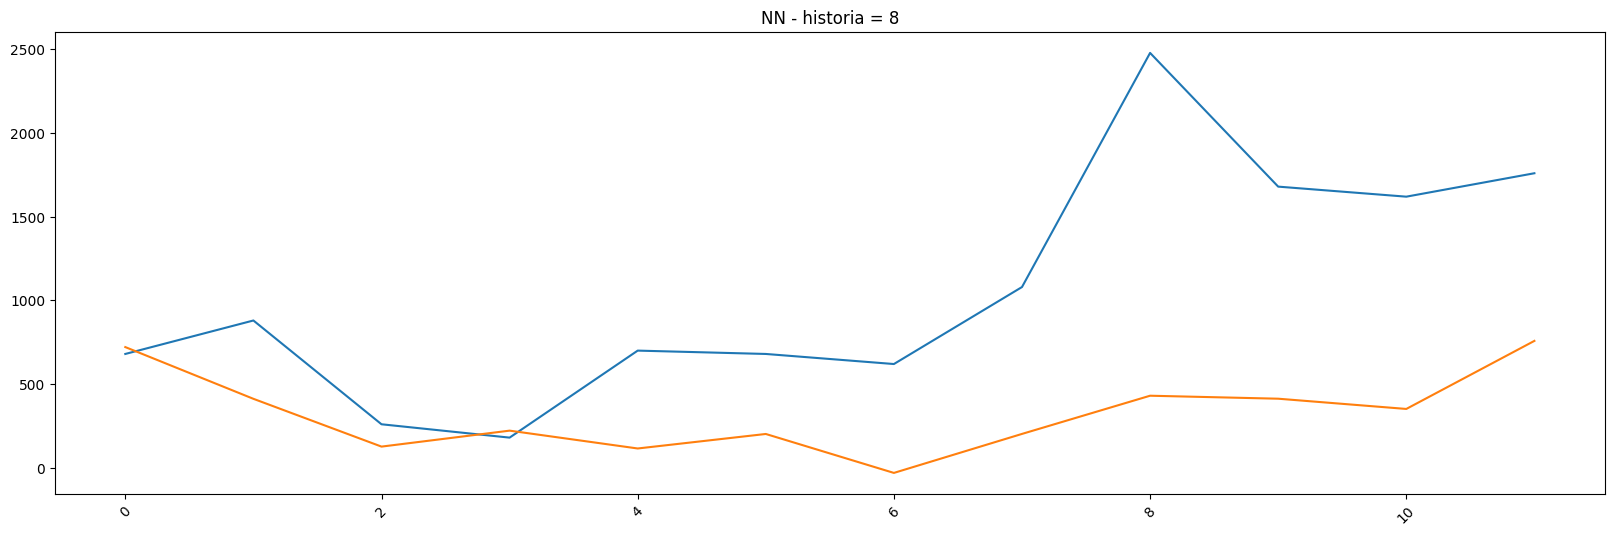

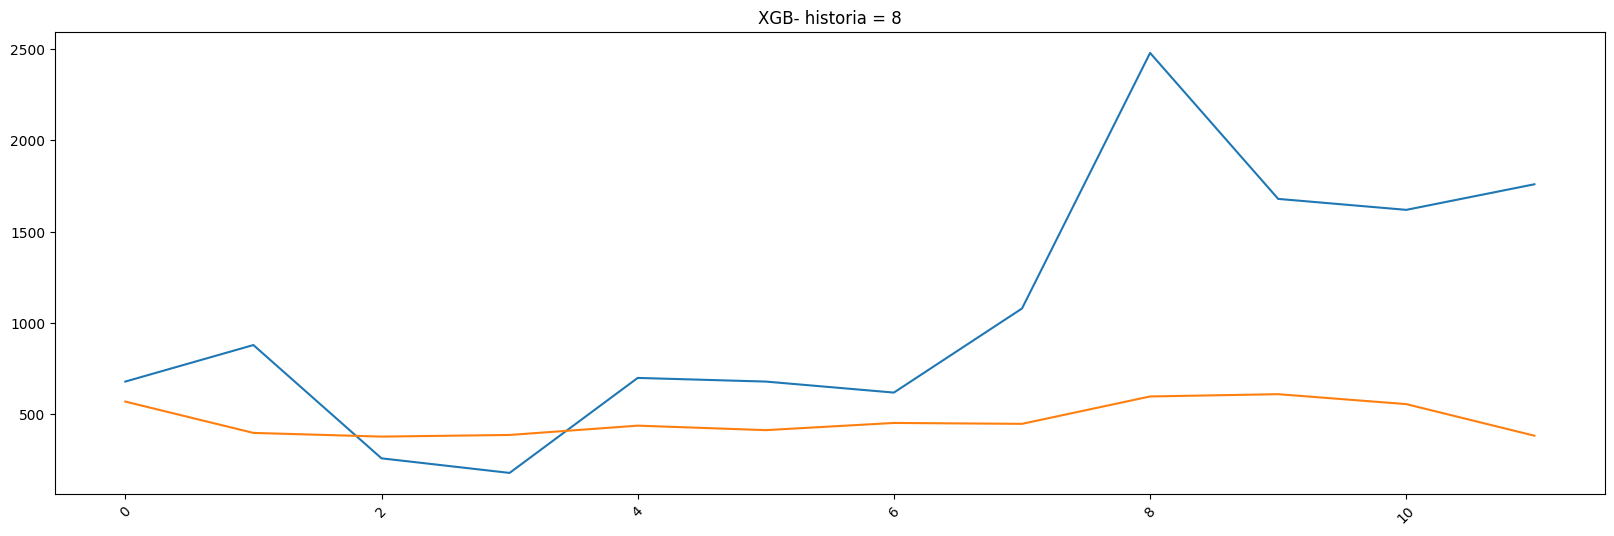

(68,) (68, 54)
(68,) (68, 54)
Random Forest Regressor:
Mejores parámetros: {'max_depth': 30, 'n_estimators': 50}
Mejor precisión (neg_mean_absolute_error): -0.07
Error absoluto medio (MAE): 0.23

Neural Network Regressor:
Mejores parámetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Mejor precisión (neg_mean_absolute_error): -0.08
Error absoluto medio (MAE): 0.31

XGBoost Regressor:
Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Mejor precisión (neg_mean_absolute_error): -0.06
Error absoluto medio (MAE): 0.26


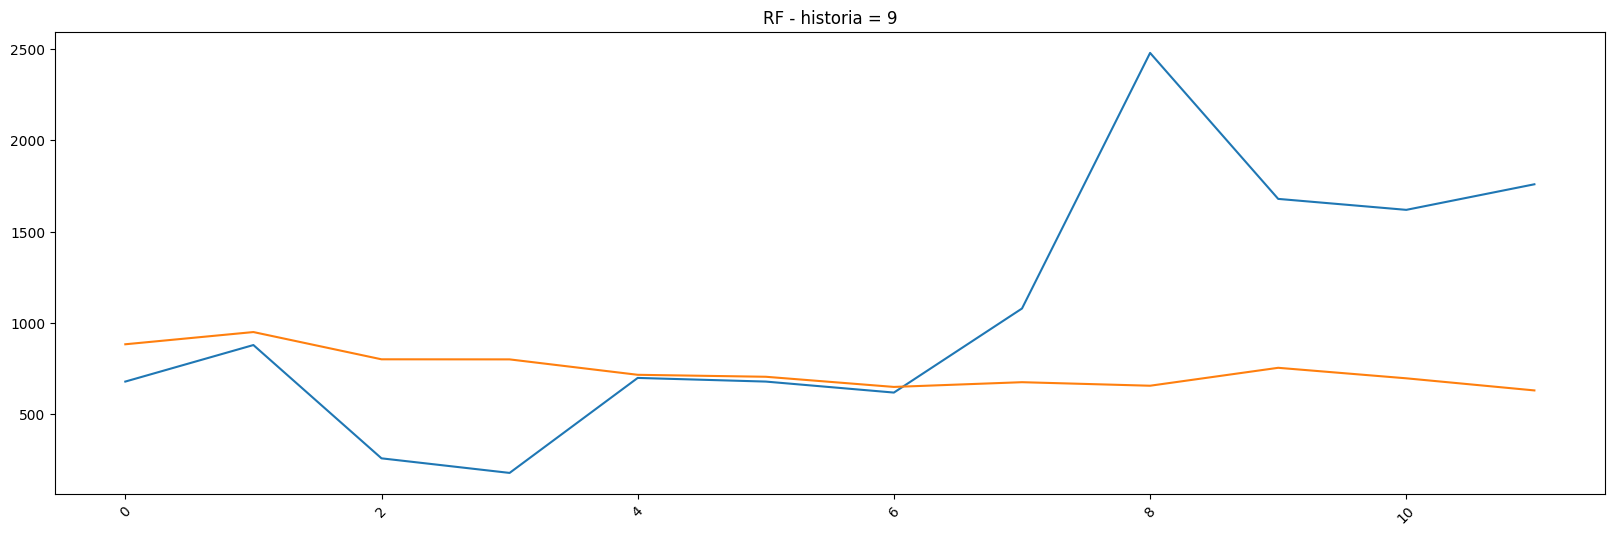

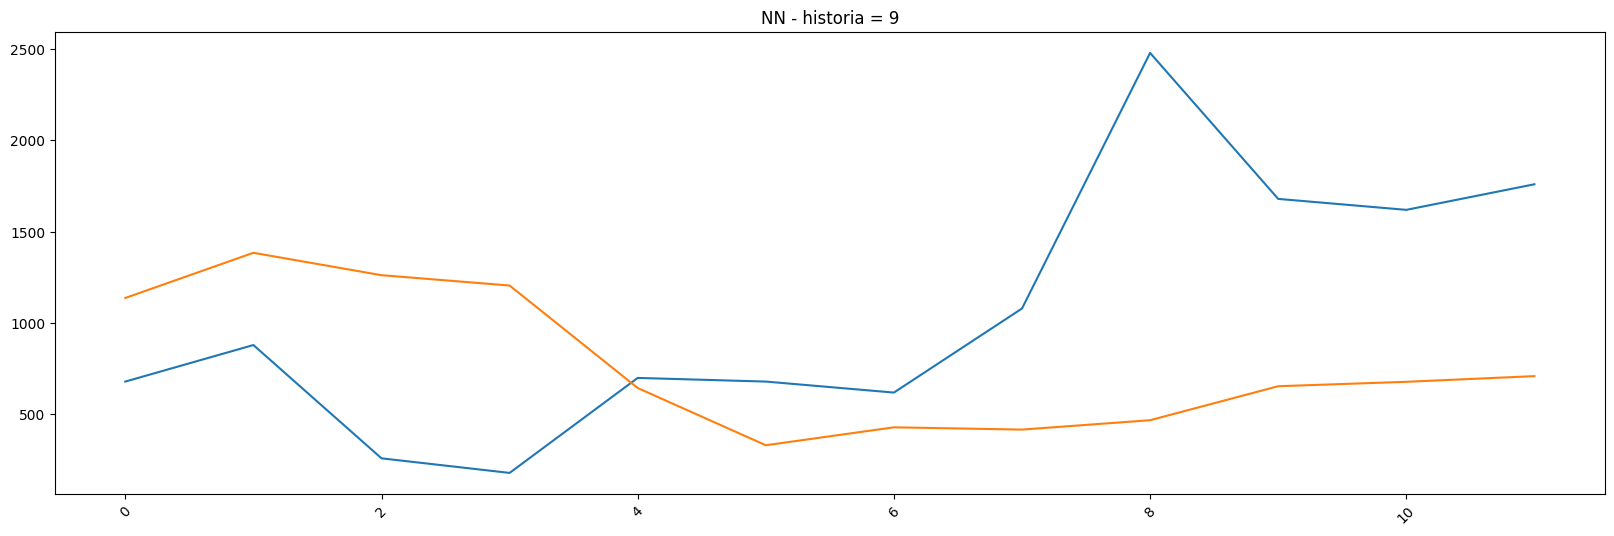

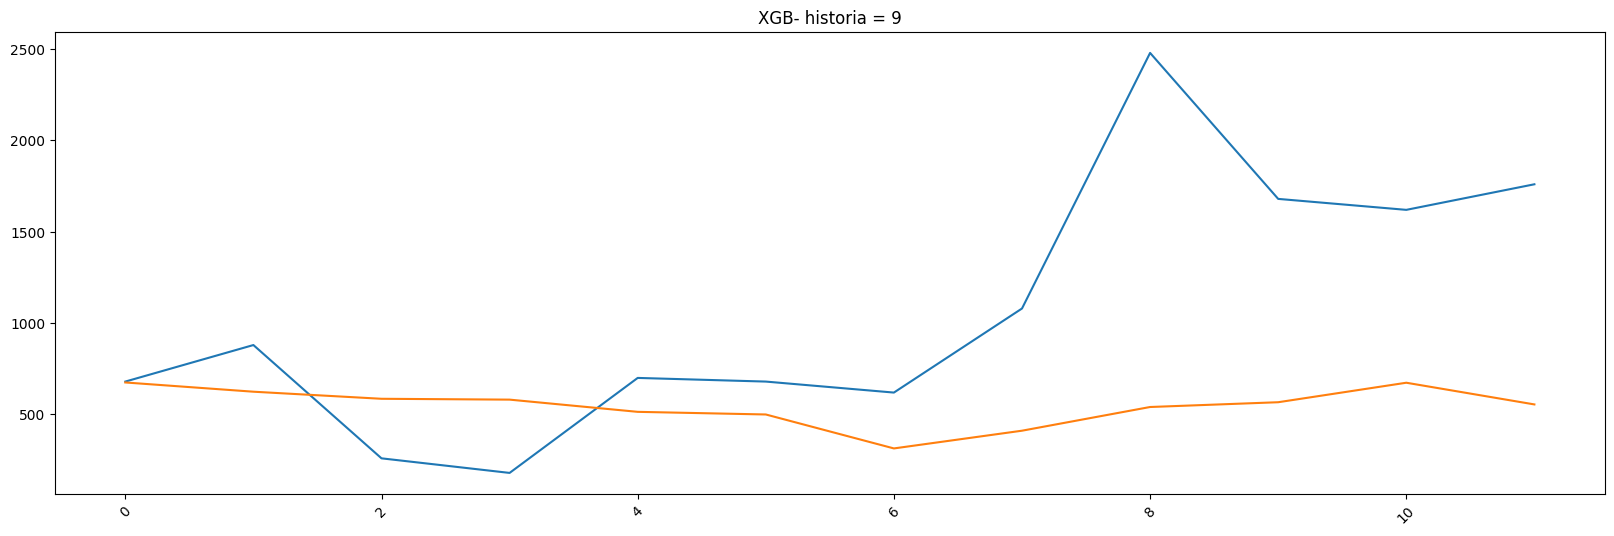

(67,) (67, 60)
(67,) (67, 60)
Random Forest Regressor:
Mejores parámetros: {'max_depth': 10, 'n_estimators': 50}
Mejor precisión (neg_mean_absolute_error): -0.07
Error absoluto medio (MAE): 0.23

Neural Network Regressor:
Mejores parámetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
Mejor precisión (neg_mean_absolute_error): -0.08
Error absoluto medio (MAE): 0.28

XGBoost Regressor:
Mejores parámetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Mejor precisión (neg_mean_absolute_error): -0.08
Error absoluto medio (MAE): 0.29


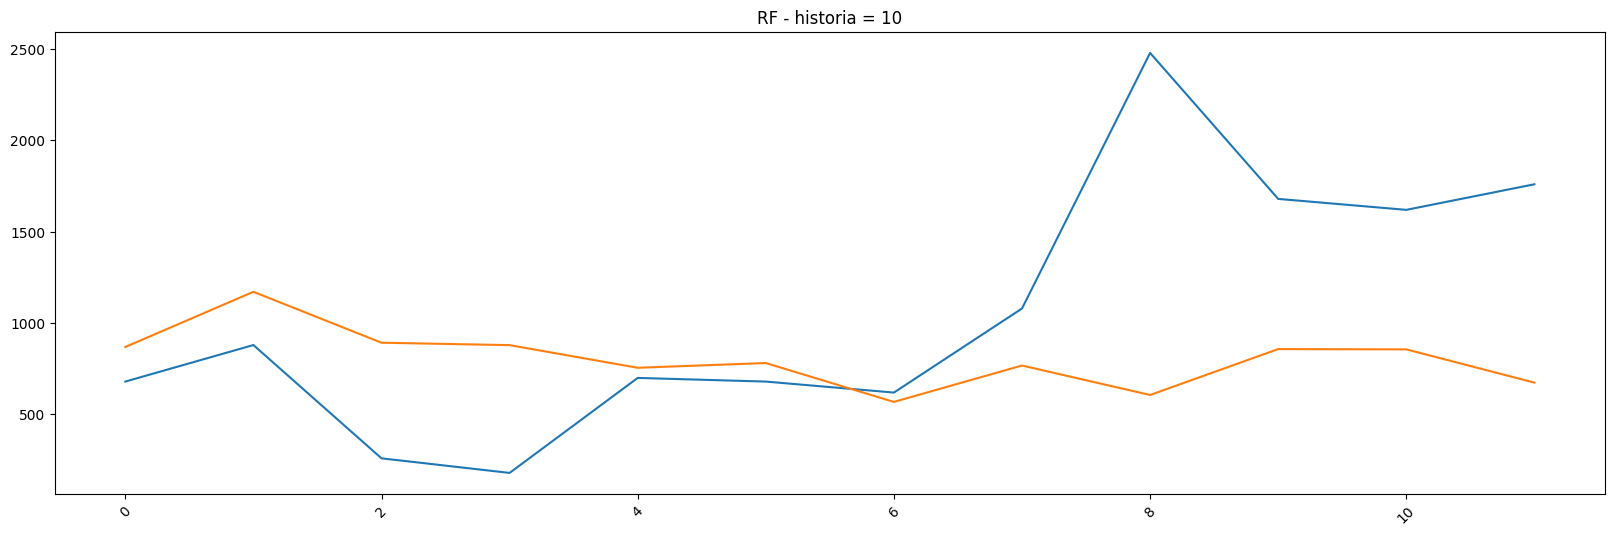

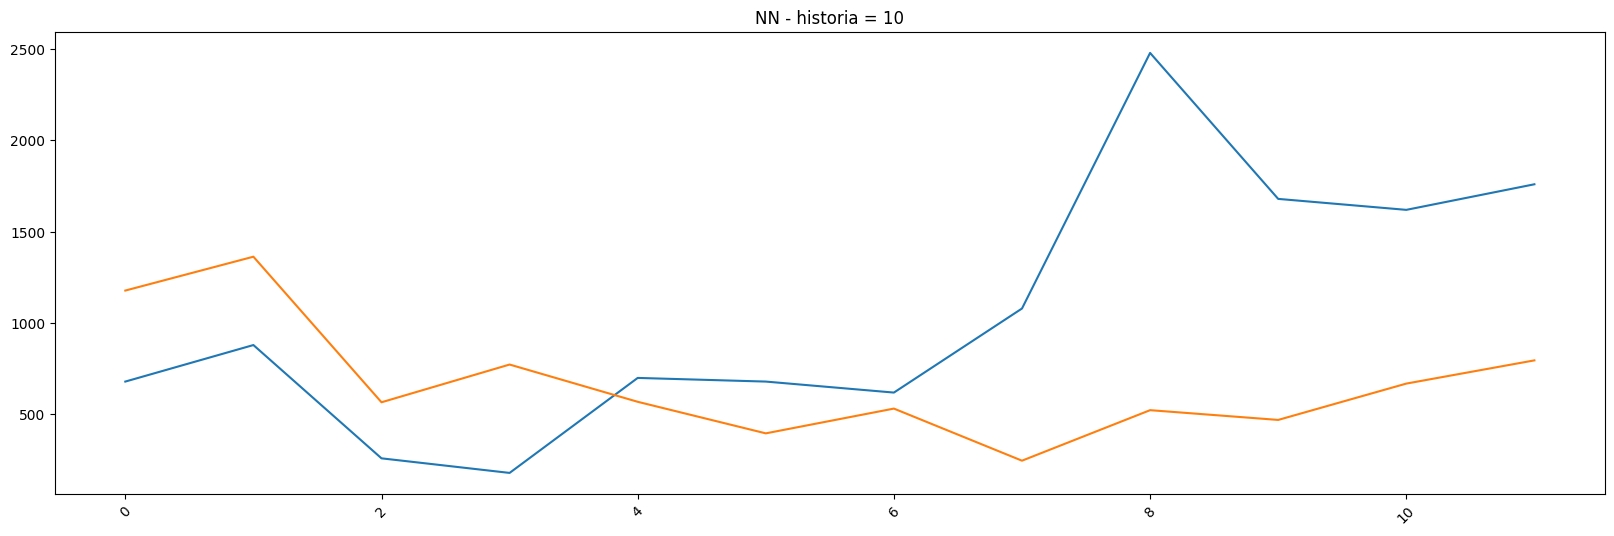

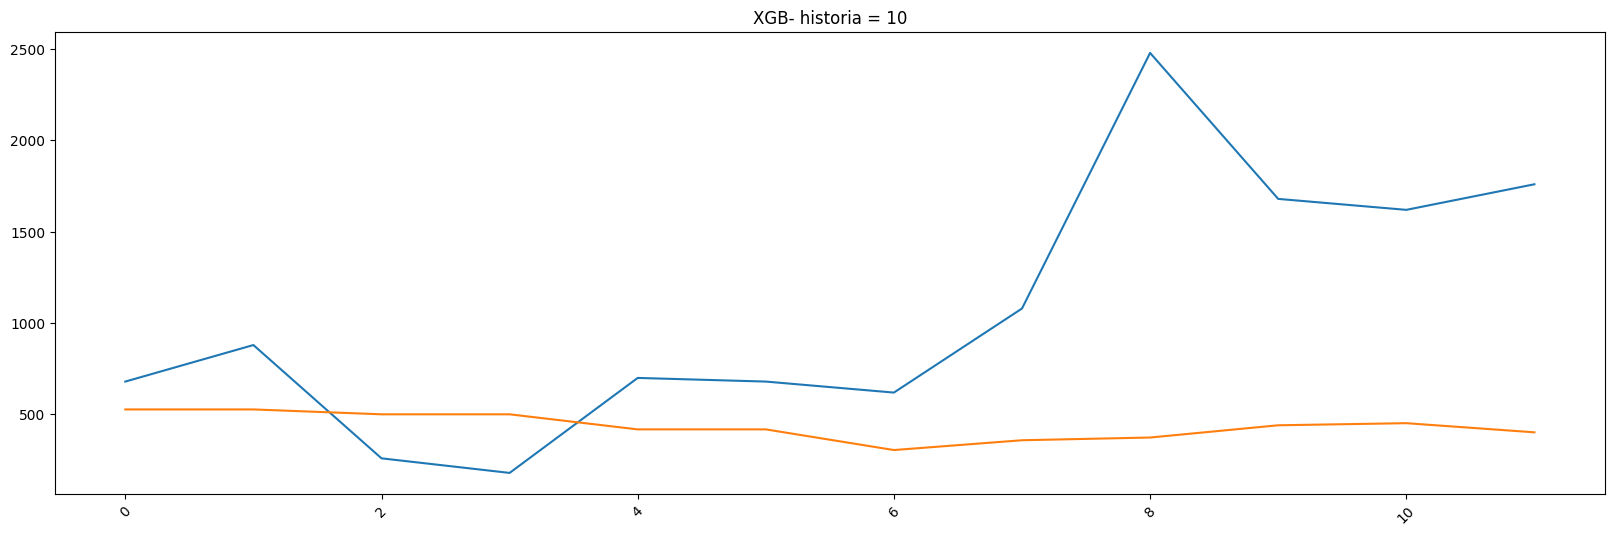

(66,) (66, 66)
(66,) (66, 66)
Random Forest Regressor:
Mejores parámetros: {'max_depth': 30, 'n_estimators': 100}
Mejor precisión (neg_mean_absolute_error): -0.07
Error absoluto medio (MAE): 0.25

Neural Network Regressor:
Mejores parámetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Mejor precisión (neg_mean_absolute_error): -0.09
Error absoluto medio (MAE): 0.29

XGBoost Regressor:
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Mejor precisión (neg_mean_absolute_error): -0.07
Error absoluto medio (MAE): 0.27


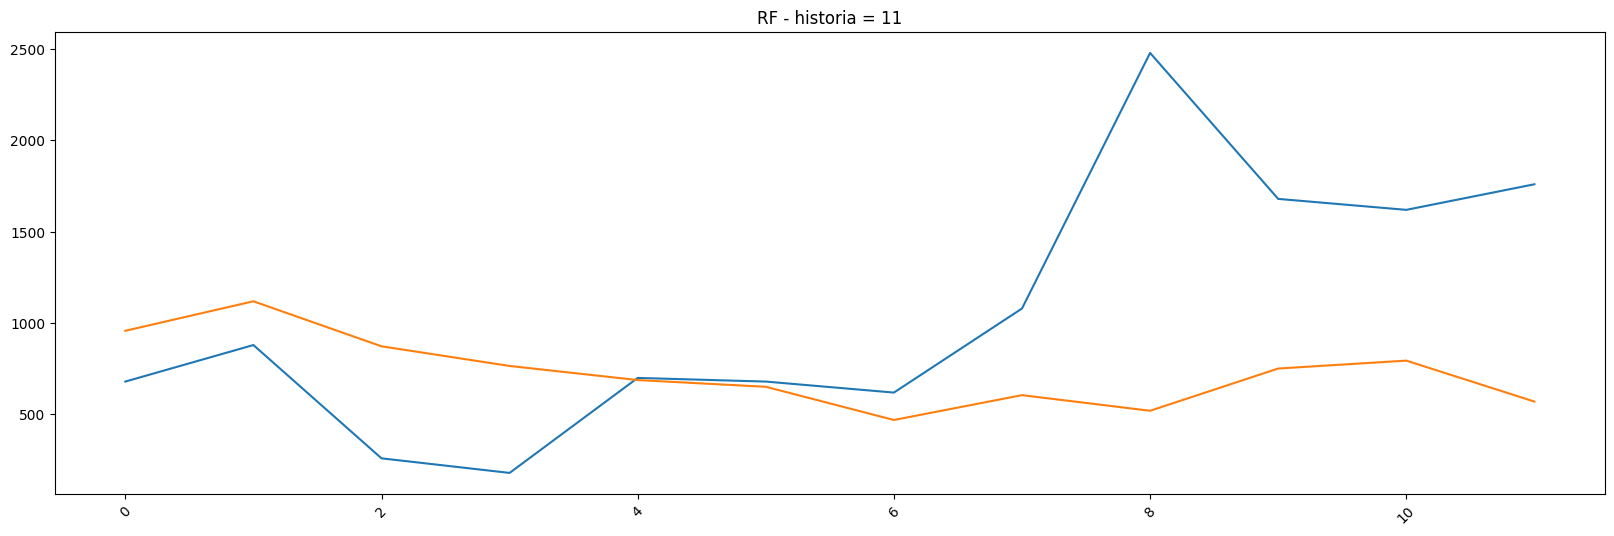

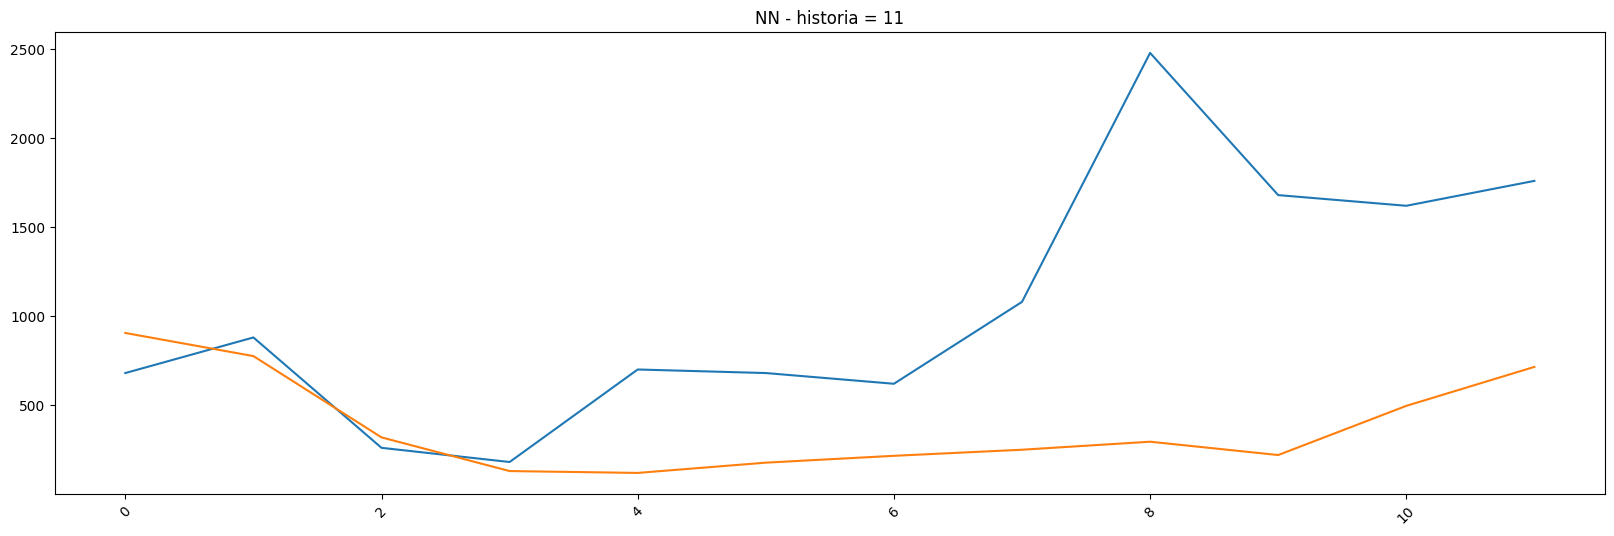

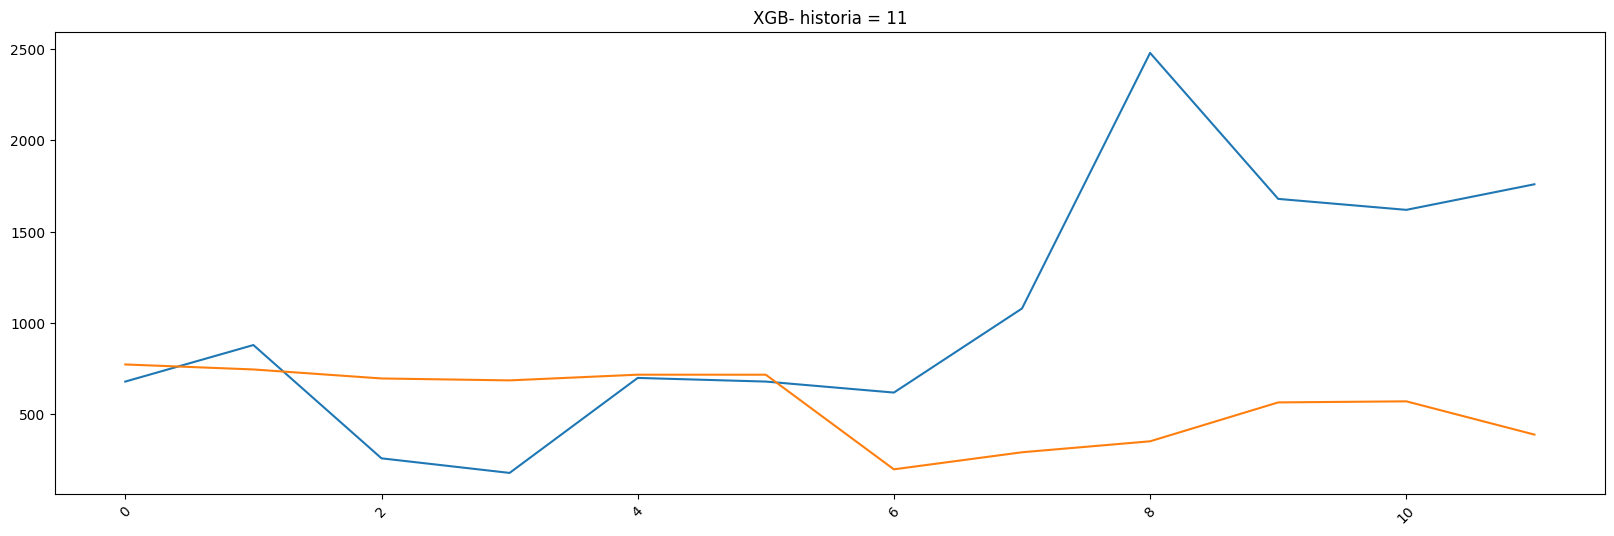

(65,) (65, 72)
(65,) (65, 72)
Random Forest Regressor:
Mejores parámetros: {'max_depth': 10, 'n_estimators': 50}
Mejor precisión (neg_mean_absolute_error): -0.07
Error absoluto medio (MAE): 0.24

Neural Network Regressor:
Mejores parámetros: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Mejor precisión (neg_mean_absolute_error): -0.09
Error absoluto medio (MAE): 0.28

XGBoost Regressor:
Mejores parámetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Mejor precisión (neg_mean_absolute_error): -0.07
Error absoluto medio (MAE): 0.27


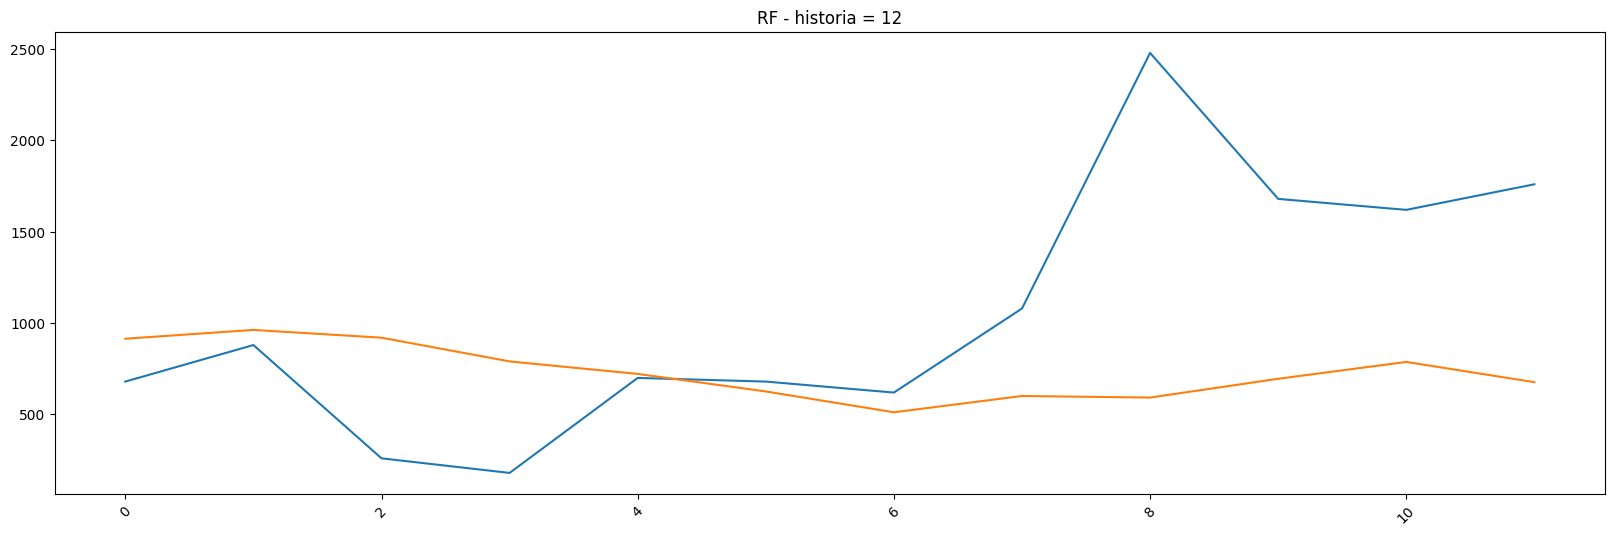

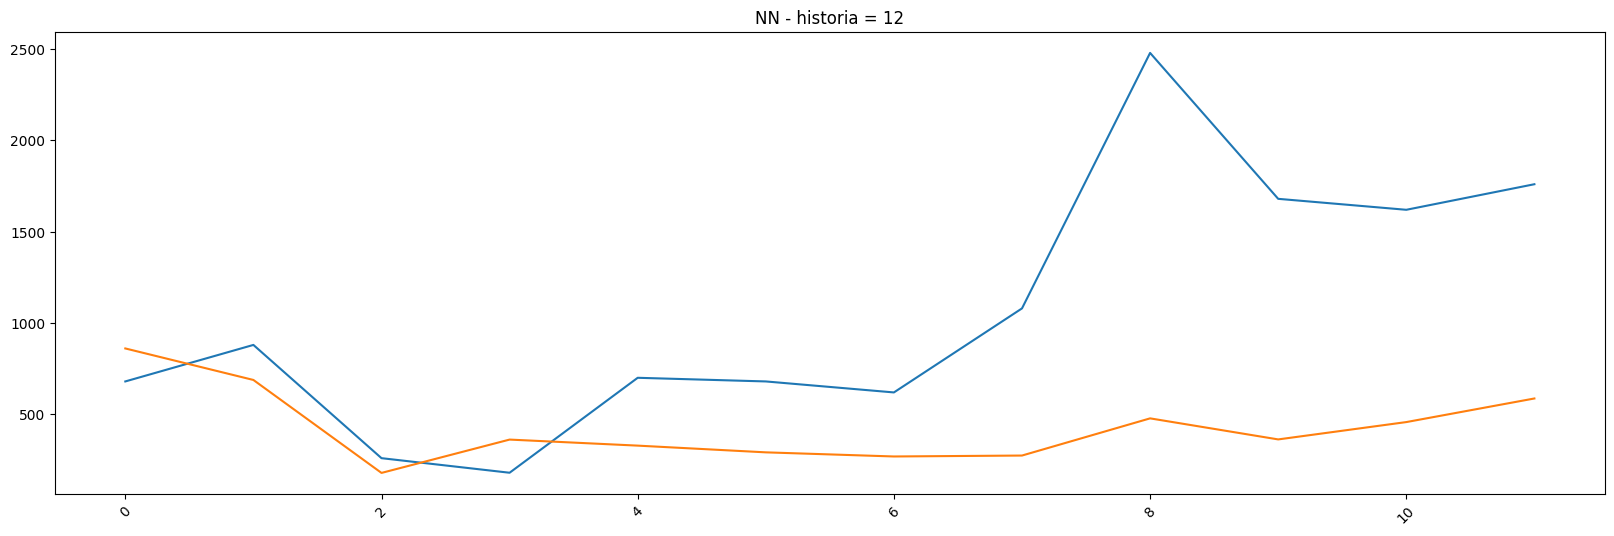

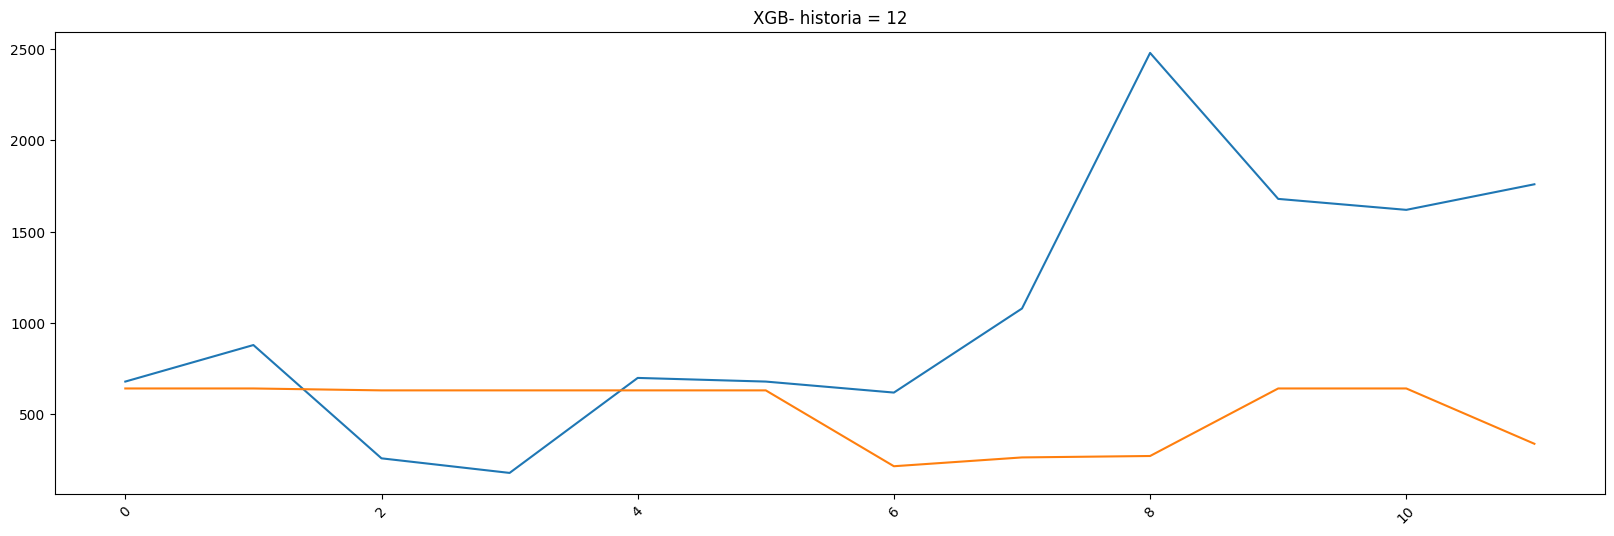

In [68]:
from sklearn.preprocessing import MinMaxScaler


for historia in range(1,13):

    arreglo = convierte_df_historico(dfTotal.drop('FechaMes', axis=1), historia)

    # obtenemos la data
    y = arreglo[:, 0]
    X = arreglo[:, 1:]

    print(y.shape, X.shape)

    # escalamos
    y_scaler = MinMaxScaler()
    X_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y.reshape(-1,1))
    X_scaled = X_scaler.fit_transform(X)


    y_scaled = y_scaled.ravel() # lo devuelve a (-1,)
    print(y_scaled.shape, X_scaled.shape)

    # corteTrainTest señala qué dejar en train y qué en test
    corteTrainTest = len(y) - 12

    y_train = y_scaled[0:corteTrainTest-1]
    X_train = X_scaled[0:corteTrainTest-1]
    y_test = y_scaled[corteTrainTest:]
    X_test = X_scaled[corteTrainTest:]


    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.neural_network import MLPRegressor
    from sklearn.metrics import mean_absolute_error
    import xgboost as xgb

    # Supongamos que tienes un arreglo de NumPy con tus datos
    # X contiene las variables X0 a X10 y Y contiene la variable objetivo

    # Definir los modelos y sus parámetros a probar
    parametros_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30]
    }

    parametros_nn = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive']
    }

    parametros_xgb = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2]
    }

    # Crear los modelos
    modelo_rf = RandomForestRegressor()
    modelo_nn = MLPRegressor(max_iter=1000)
    modelo_xgb = xgb.XGBRegressor()

    # Configurar GridSearchCV para cada modelo
    grid_rf = GridSearchCV(modelo_rf, parametros_rf, cv=5, scoring='neg_mean_absolute_error')
    grid_nn = GridSearchCV(modelo_nn, parametros_nn, cv=5, scoring='neg_mean_absolute_error')
    grid_xgb = GridSearchCV(modelo_xgb, parametros_xgb, cv=5, scoring='neg_mean_absolute_error')

    # Realizar la búsqueda de hiperparámetros y cross-validation
    grid_rf.fit(X_train, y_train)
    grid_nn.fit(X_train, y_train)
    grid_xgb.fit(X_train, y_train)

    # Obtener las predicciones con los mejores modelos
    mejor_modelo_rf = grid_rf.best_estimator_
    mejor_modelo_nn = grid_nn.best_estimator_
    mejor_modelo_xgb = grid_xgb.best_estimator_

    y_pred_rf = mejor_modelo_rf.predict(X_test)
    y_pred_nn = mejor_modelo_nn.predict(X_test)
    y_pred_xgb = mejor_modelo_xgb.predict(X_test)

    # Calcular el error absoluto medio (MAE)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    mae_nn = mean_absolute_error(y_test, y_pred_nn)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

    # Mostrar los mejores parámetros, la mejor puntuación y el MAE
    print("Random Forest Regressor:")
    print(f"Mejores parámetros: {grid_rf.best_params_}")
    print(f"Mejor precisión (neg_mean_absolute_error): {grid_rf.best_score_:.2f}")
    print(f"Error absoluto medio (MAE): {mae_rf:.2f}")

    print("\nNeural Network Regressor:")
    print(f"Mejores parámetros: {grid_nn.best_params_}")
    print(f"Mejor precisión (neg_mean_absolute_error): {grid_nn.best_score_:.2f}")
    print(f"Error absoluto medio (MAE): {mae_nn:.2f}")

    print("\nXGBoost Regressor:")
    print(f"Mejores parámetros: {grid_xgb.best_params_}")
    print(f"Mejor precisión (neg_mean_absolute_error): {grid_xgb.best_score_:.2f}")
    print(f"Error absoluto medio (MAE): {mae_xgb:.2f}")

    y_pred_nn_original = y_scaler.inverse_transform(y_pred_nn.reshape(-1,1))
    y_pred_rf_original = y_scaler.inverse_transform(y_pred_rf.reshape(-1,1))
    y_pred_xgb_original = y_scaler.inverse_transform(y_pred_xgb.reshape(-1,1))

    y_test_original = y_scaler.inverse_transform(y_test.reshape(-1,1))

    # obtenemos el eje x para graficar
    x = np.arange(len(y_test_original))

    # RF
    plt.figure(figsize=(20, 6))
    sns.lineplot(x=x, y=y_test_original.ravel())
    sns.lineplot(x=x, y=y_pred_rf_original.ravel())
    plt.xticks(rotation=45)
    plt.title('RF - historia = ' + str(historia))
    plt.show()

    # NN
    plt.figure(figsize=(20, 6))
    sns.lineplot(x=x, y=y_test_original.ravel())
    sns.lineplot(x=x, y=y_pred_nn_original.ravel())
    plt.xticks(rotation=45)
    plt.title('NN - historia = ' + str(historia))
    plt.show()

    # XGB
    plt.figure(figsize=(20, 6))
    sns.lineplot(x=x, y=y_test_original.ravel())
    sns.lineplot(x=x, y=y_pred_xgb_original.ravel())
    plt.xticks(rotation=45)
    plt.title('XGB- historia = ' + str(historia))
    plt.show()